<a href="https://www.kaggle.com/code/gustanasatiawan/satellite-image-classify?scriptVersionId=199458597" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Intro

## Background Problem

Earth is currently the only planet on which humans and other creatures live. Sadly, human activities worsen the Earth's condition over time through global warming. To monitor earth's condition, scientists have been analyzing images that captured from artificial satellites.

## Objective

To help scientist classify images that captured from satellite, I will create a deep learning model that can automate that process. Thus, they can focused on more important tasks.

- There are 4 classes of images that will be used to train the model, such as: dessert, green area, water, and cloudy.
- In this project, I will consider that all image classes are equally important, thus the metric I choose is accuracy.
- To create a robust model for prediction, minimum accuracy that the model must produce is 90%.

Additional Note:
- I'm using 5% as score difference threshold to identify whether a model overfitting or not.
- This threshold applied for both accuracy and loss score

- Hence, this project aims to build a model with a difference in accuracy and loss scores of less than 5%.

# Import Libs

In [1]:
import os
from os.path import join as path_join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Input, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import DataFrameIterator

from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
# define dir const
IMG_DIR_PATH = "/kaggle/input/data"

In [3]:
# define image class list
img_classes = [dirname for dirname in os.listdir(IMG_DIR_PATH)]
img_classes

['cloudy', 'desert', 'green_area', 'water']

In [4]:
# define image examples to plot
img_examples_dict = {}

for img_class in img_classes:
    img_file_path = []

    for img_file_name in os.listdir(path_join(IMG_DIR_PATH, img_class))[:5]:
        img_file_path.append(
            path_join(IMG_DIR_PATH, img_class, img_file_name)
        )
        
    img_examples_dict[img_class] = img_file_path

In [5]:
img_examples_dict

{'cloudy': ['/kaggle/input/data/cloudy/train_17406.jpg',
  '/kaggle/input/data/cloudy/train_28684.jpg',
  '/kaggle/input/data/cloudy/train_33597.jpg',
  '/kaggle/input/data/cloudy/train_34079.jpg',
  '/kaggle/input/data/cloudy/train_30586.jpg'],
 'desert': ['/kaggle/input/data/desert/desert(14).jpg',
  '/kaggle/input/data/desert/desert(217).jpg',
  '/kaggle/input/data/desert/desert(204).jpg',
  '/kaggle/input/data/desert/desert(1030).jpg',
  '/kaggle/input/data/desert/desert(1080).jpg'],
 'green_area': ['/kaggle/input/data/green_area/Forest_2838.jpg',
  '/kaggle/input/data/green_area/Forest_205.jpg',
  '/kaggle/input/data/green_area/Forest_2038.jpg',
  '/kaggle/input/data/green_area/Forest_344.jpg',
  '/kaggle/input/data/green_area/Forest_2181.jpg'],
 'water': ['/kaggle/input/data/water/SeaLake_926.jpg',
  '/kaggle/input/data/water/SeaLake_907.jpg',
  '/kaggle/input/data/water/SeaLake_844.jpg',
  '/kaggle/input/data/water/SeaLake_830.jpg',
  '/kaggle/input/data/water/SeaLake_2215.jpg']

In [6]:
def read_img_rgb(img_file_path: str)->np.array:
    """
    Return image using cv2 using rgb channel as 3-dimensional array
    
        param:
            img_file_path (str): image file path to load
            
        return:
            3-dimensional array that represent r,g,b color channel
    """

    # openCV read image use bgr channel as default
    # but matplotlib use rgb channel
    # thus, I read the image using openCV first, then convert the color channel into rgb
    img = cv2.imread(img_file_path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
def show_subplot_img(
    ncols: int, 
    figsize: tuple, 
    imgs_dict: dict, 
    nrows: int=1,
    cmap: str="viridis",
    is_plot_rgb: bool=False
)->None:
    """
    PLot images in :imgs_dict using subplots
    
        params:
            ncols (int): number of columns for subplot
            figsize (tuple): figure size of the subplot (w, h) in inches
            imgs_dict (dict): 
            nrows (int): number of rows for subplot [default=1]
            cmap (str): default colormap used in matplotlib
            is_plot_rgb (bool): whether plot image on each color channel (r, g, b) separately or plot as whole (rgb) [default=False]
    
        return: None
    """
    
    if(not is_plot_rgb):
        for i, (img_class, img_dict) in enumerate(imgs_dict.items()):
            fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
            
            for j, img in enumerate(img_dict):
                axs[j].imshow(img, cmap)
                axs[j].title.set_text(f"image {j+1}")
                
            fig.suptitle(img_class)
            
        plt.show()

    else:
        rgb_label=["r", "g", "b"]

        for i, (img_class, img_dict) in enumerate(imgs_dict.items()):
            fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

            for j, img in enumerate(img_dict):
                axs[j].imshow(img, cmap)
                axs[j].title.set_text(f"channel {rgb_label[j]}")

            fig.suptitle(img_class)

        plt.show()

In [8]:
# I found out that images in dataset are having different size
# In this cell I do comprehensive analysis to find out 
# how many type of image sizes appear in the dataset

img_shape_64_64 = {}
img_shape_256_256 = {}
img_shape_else = []

for img_class in img_classes:
    img_64_64 = []
    img_256_256 = []
    for img_file_name in os.listdir(path_join(IMG_DIR_PATH, img_class)):
        img_read = read_img_rgb(path_join(IMG_DIR_PATH, img_class, img_file_name))
        if(img_read.shape==(64,64,3)):
            img_64_64.append(img_file_name)
        elif(img_read.shape==(256,256,3)):
            img_256_256.append(img_file_name)
        else:
            img_shape_else.append([img_read.shape, img_file_name])
    img_shape_64_64[img_class] = img_64_64
    img_shape_256_256[img_class] = img_256_256

print("image shape 64x64")
for k, v in img_shape_64_64.items():
    print(f"{k}: {len(v)}")

print("\nimage shape 256x256")
for k, v in img_shape_256_256.items():
    print(f"{k}: {len(v)}")

print("\nother shape: ", len(img_shape_else))

image shape 64x64
cloudy: 0
desert: 0
green_area: 1500
water: 1500

image shape 256x256
cloudy: 1500
desert: 1131
green_area: 0
water: 0

other shape:  0


In [9]:
# read 2 rgb images as examples

IMG_RGB_EXAMPLE1 = read_img_rgb(path_join(IMG_DIR_PATH, "green_area/Forest_344.jpg"))

IMG_RGB_EXAMPLE2 = read_img_rgb(path_join(IMG_DIR_PATH, "cloudy/train_33597.jpg"))

In [10]:
# print size of example images
print("ex img1 shape: ", IMG_RGB_EXAMPLE1.shape)
print("ex img2 shape: ", IMG_RGB_EXAMPLE2.shape)

ex img1 shape:  (64, 64, 3)
ex img2 shape:  (256, 256, 3)


- The in-depth analysis shows that the dataset contains 2 types of images in terms of size, such as 64x64x3 and 256x256x3.
- Since deep learning model requires images in the same size, thus I will use image size of 128x128x3 because it's a balanced choice that halves 256 and doubles 64

In [11]:
# defined image shapes with and without channel
IMG_SHAPE = (128, 128)
IMG_SHAPE_WITH_CHANNEL = (128, 128, 3)

## EDA

In [12]:
# read all images and store into dict
img_rgbs_dict={}
for k, img_file_paths in img_examples_dict.items():
    img_read = []
    
    for img_file_path in img_file_paths:
        img_read.append(read_img_rgb(img_file_path))
    img_rgbs_dict[k] = img_read

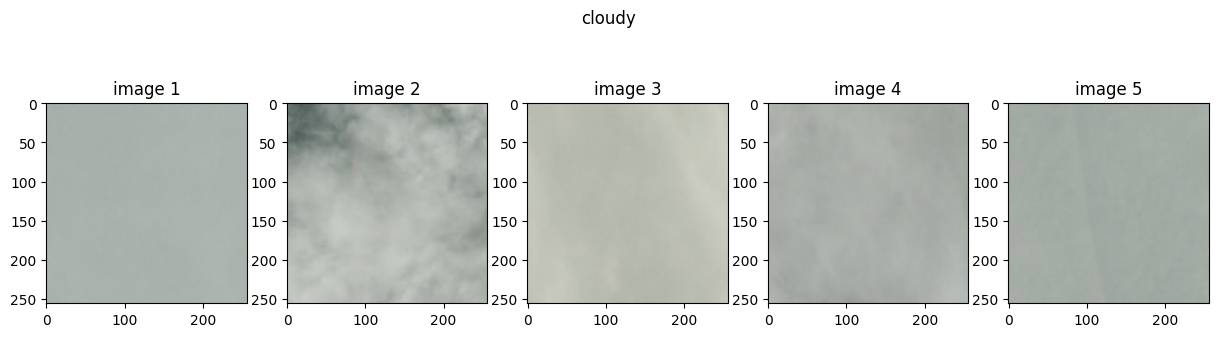

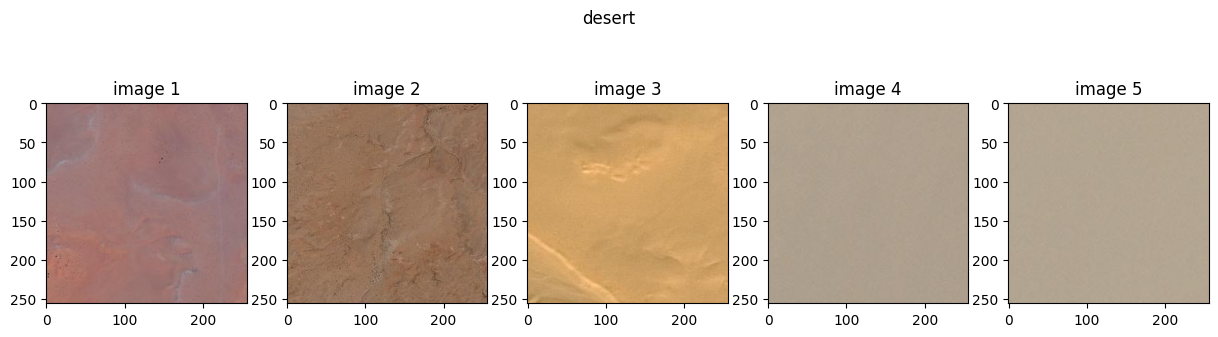

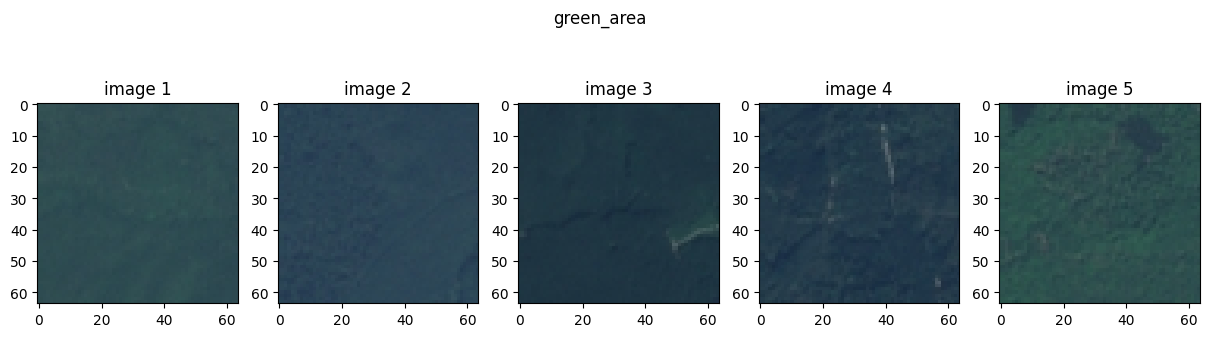

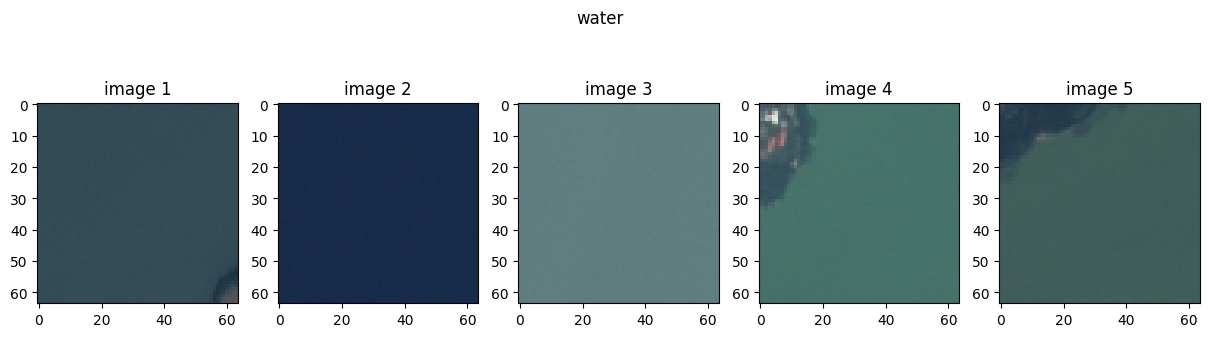

In [13]:
# plot 5 image for each class
show_subplot_img(5, (15, 4), img_rgbs_dict)

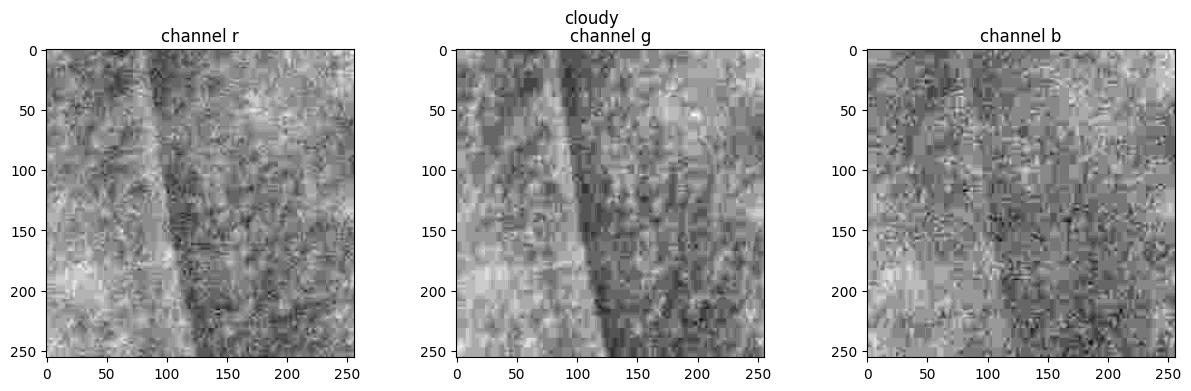

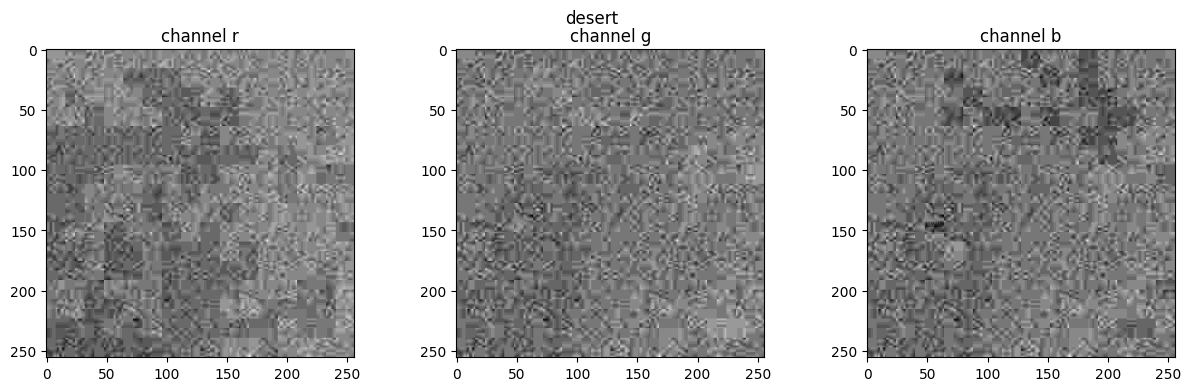

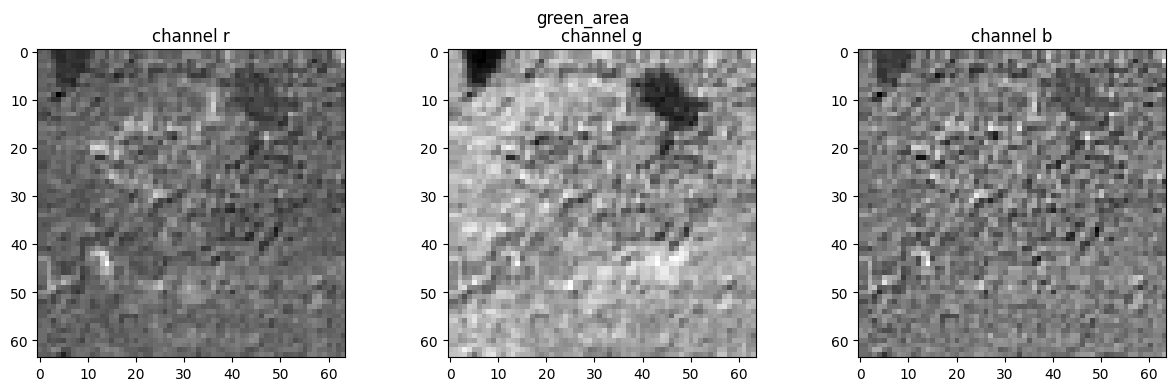

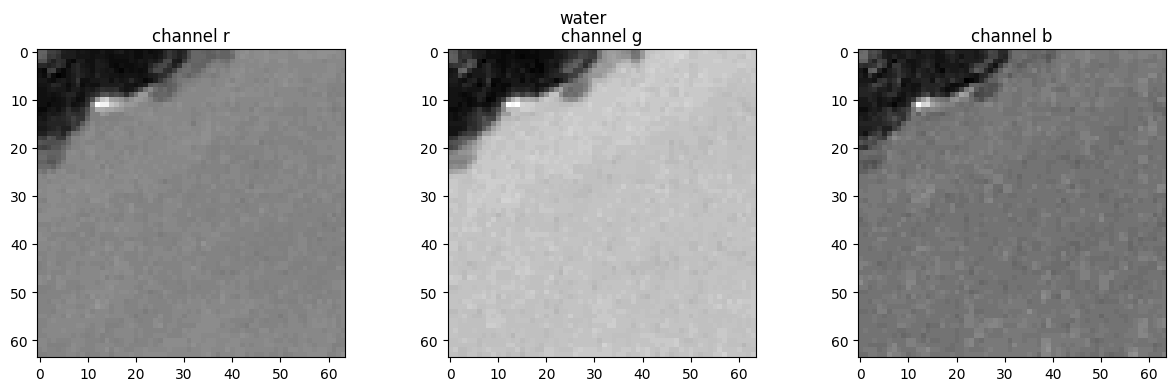

In [14]:
# plot rgb for each img class on 5th image
for img_class, img_rgbs in img_rgbs_dict.items():

    # split each color channel of an image
    r,g,b = cv2.split(img_rgbs[4])
    img_wrapper_dict = {img_class: [r,g,b]}
    
    show_subplot_img(3, (15, 4), img_wrapper_dict, cmap="gray", is_plot_rgb=True)

- The visualizations shown that charactheristics of images based on each color channel are simmilar.
- But, when it comes to colors, it's easier to differentiate these images
    - Cloudy area: gray
    - Dessert: somewhat brown
    - Green area: mixture of blue and green with contours that spread into all area
    - Water: mixture of blue and green that might contains objects

- Based on my analysis, these images can be distinguished by image's objects and colors. `Thus, I will use rbg image color to train the model`
- But, `I also will create a model that trained using grayscale color to prove my analysis`

# Feature Engineering

In this project, I will do some image augmentations to add variability on train and validation data, such as:
- Illumination or brightness
- Contrast

Hopefully these image augmentations will help the model to understand each class's characteristics better, thus increase the overall accuracy.

## Illuminate

In [15]:
# define matrix to adjust image's brightness
matrix_bright = np.ones(IMG_RGB_EXAMPLE2.shape, dtype="uint8") * 50

In [16]:
# brighten an image
img_rgb_brightened = cv2.add(
    IMG_RGB_EXAMPLE2,
    matrix_bright
)

# darken an image
img_rgb_darkened = cv2.subtract(
    IMG_RGB_EXAMPLE2, 
    matrix_bright
)

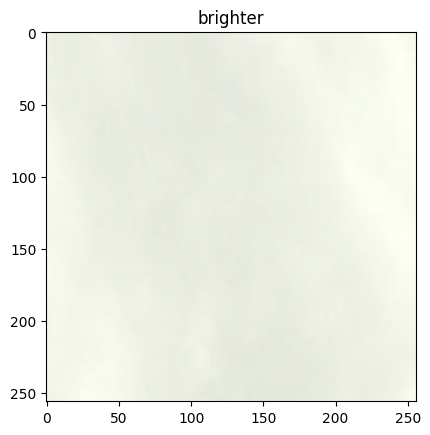

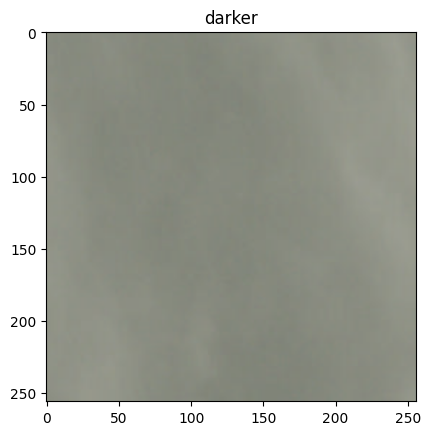

In [17]:
# plot adjusted brigthness image
plt.imshow(img_rgb_brightened)
plt.title("brighter")
plt.show()

plt.imshow(img_rgb_darkened)
plt.title("darker")
plt.show()

## Contrast

In [18]:
# define matrix for increasing and decreasing contrast
matrix_contrast_up = np.ones(IMG_RGB_EXAMPLE2.shape) * 1.6
matrix_contrast_down = np.ones(IMG_RGB_EXAMPLE2.shape) * 0.4

In [19]:
# adjust images' contrasts
img_rgb_cont_up   = np.uint8(
    cv2.multiply(
        np.float64(IMG_RGB_EXAMPLE2), 
        matrix_contrast_up
    )
)

img_rgb_brightened_cont_up = np.uint8(
    cv2.multiply(
        np.float64(img_rgb_brightened), 
        matrix_contrast_up)
    )

img_rgb_cont_down = np.uint8(
    cv2.multiply(
        np.float64(IMG_RGB_EXAMPLE2), 
        matrix_contrast_down
    )
)

img_rgb_darkened_cont_down = np.uint8(
    cv2.multiply(
        np.float64(img_rgb_darkened), 
        matrix_contrast_down
    )
)

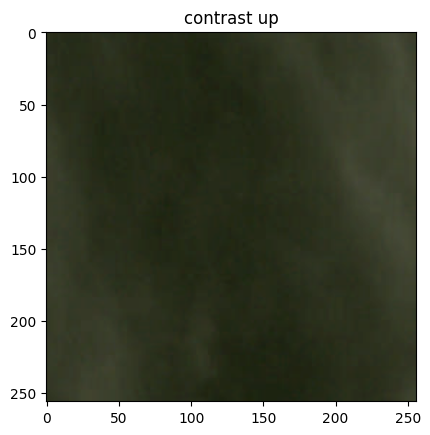

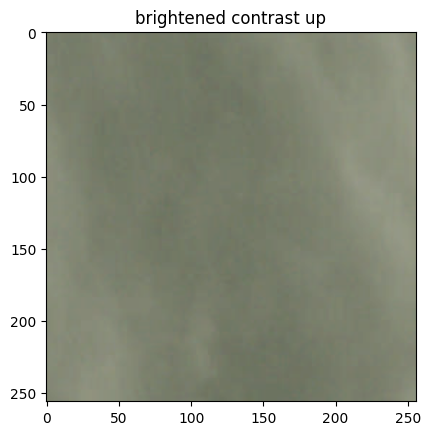

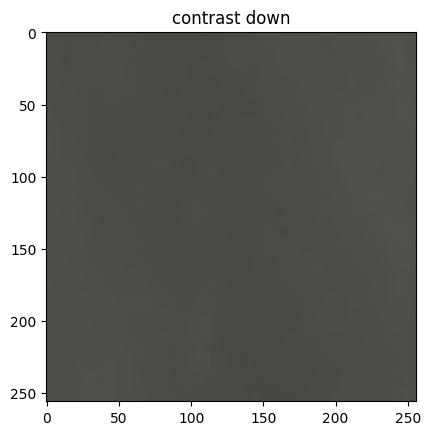

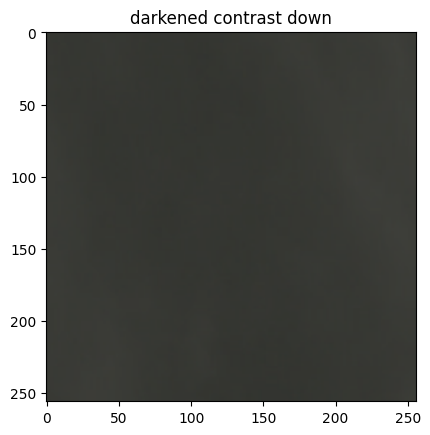

In [20]:
# plot adjusted contrast images
plt.imshow(img_rgb_cont_up)
plt.title("contrast up")
plt.show()

plt.imshow(img_rgb_brightened_cont_up)
plt.title("brightened contrast up")
plt.show()

plt.imshow(img_rgb_cont_down)
plt.title("contrast down")
plt.show()

plt.imshow(img_rgb_darkened_cont_down)
plt.title("darkened contrast down")
plt.show()

In [21]:
# provide list of labels and image paths to create dataframe
labels = [] 
paths = []

for img_class in img_classes:
    for file_name in os.listdir(path_join(IMG_DIR_PATH, img_class)):
        labels.append(img_class)
        paths.append(path_join(IMG_DIR_PATH, img_class, file_name))

In [22]:
print(labels[:5])
print(labels[-5:])

['cloudy', 'cloudy', 'cloudy', 'cloudy', 'cloudy']
['water', 'water', 'water', 'water', 'water']


In [23]:
print(paths[:5])
print(paths[-5:])

['/kaggle/input/data/cloudy/train_17406.jpg', '/kaggle/input/data/cloudy/train_28684.jpg', '/kaggle/input/data/cloudy/train_33597.jpg', '/kaggle/input/data/cloudy/train_34079.jpg', '/kaggle/input/data/cloudy/train_30586.jpg']
['/kaggle/input/data/water/SeaLake_682.jpg', '/kaggle/input/data/water/SeaLake_1614.jpg', '/kaggle/input/data/water/SeaLake_1184.jpg', '/kaggle/input/data/water/SeaLake_1427.jpg', '/kaggle/input/data/water/SeaLake_2146.jpg']


In [24]:
# create dataframe contains label and image path
img_df = pd.DataFrame(
    data={
        "label": labels,
        "path": paths
    }
)

img_df

label                                       path
0     cloudy  /kaggle/input/data/cloudy/train_17406.jpg
1     cloudy  /kaggle/input/data/cloudy/train_28684.jpg
2     cloudy  /kaggle/input/data/cloudy/train_33597.jpg
3     cloudy  /kaggle/input/data/cloudy/train_34079.jpg
4     cloudy  /kaggle/input/data/cloudy/train_30586.jpg
...      ...                                        ...
5626   water   /kaggle/input/data/water/SeaLake_682.jpg
5627   water  /kaggle/input/data/water/SeaLake_1614.jpg
5628   water  /kaggle/input/data/water/SeaLake_1184.jpg
5629   water  /kaggle/input/data/water/SeaLake_1427.jpg
5630   water  /kaggle/input/data/water/SeaLake_2146.jpg

[5631 rows x 2 columns]

In [25]:
def get_index_sample_without_replace(
    df: pd.DataFrame, 
    sample_size: int
):
    """
    Get :sample_size number of indexes without replacement for sample data from :df
    
        param:
            df (pd.DataFrame): data source that contains label and path of each image
            
        return:
            index of samples as list
    """
    
    return list(
        df.sample(
            n=sample_size,
            replace=False,
            random_state=9
        ).index
    )

## Data Splitting

In [26]:
# define dict to contains number of samples of ecach image class
# used for test set
test_sizes_dict = {}

for img_class in img_df["label"].unique():
    # sample 5%
    test_sizes_dict[img_class] = int(0.05 * img_df[img_df["label"]==img_class].shape[0])
    
test_sizes_dict

{'cloudy': 75, 'desert': 56, 'green_area': 75, 'water': 75}

In [27]:
# define list to contain index of images for the test set
test_data_idx = []
for img_class, sample_size in test_sizes_dict.items():
    test_data_idx+=get_index_sample_without_replace(
        img_df[img_df["label"]==img_class], 
        sample_size
    )

In [28]:
len(set(test_data_idx))

281

> All test data indexes are unique

In [29]:
# split dataset into 2: test & train-val
img_test_df = img_df.iloc[test_data_idx]
img_train_val_df = img_df.drop(index=test_data_idx)

In [30]:
img_train_val_df["label"].value_counts(normalize=True)

label
cloudy        0.266355
green_area    0.266355
water         0.266355
desert        0.200935
Name: proportion, dtype: float64

In [31]:
img_test_df["label"].value_counts(normalize=True)

label
cloudy        0.266904
green_area    0.266904
water         0.266904
desert        0.199288
Name: proportion, dtype: float64

In [32]:
# print shape, num of rows with missing and duplicated values
# on all image generators
for (label, df) in zip(
    ["img train-val", "img test"], 
    [img_train_val_df, img_test_df]
):
    print(label)
    print("shape: ", df.shape)
    print("number of rows with missing value: ", df.isna().sum().sum())
    print("number of rows with duplicated value: ", df.duplicated().sum(), end="\n\n")

img train-val
shape:  (5350, 2)
number of rows with missing value:  0
number of rows with duplicated value:  0

img test
shape:  (281, 2)
number of rows with missing value:  0
number of rows with duplicated value:  0



## Image Generator

In this step I will add more variances on images for training and validation. This step will make sure that the model will learn wider range of image's characteristics.
The augmentation process including:
- horizontal & vertical flip
- zoom range 1 to 1,5
- rescale 1/255 -> rescaling to decrease the image's pixels while still retaining the same information, this can make the training process faster
- batch processing -> improve training speed and generalizability

In [33]:
def create_img_generators(
    validation_split: float,
    rescale: float=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range: list=[0.5, 1], # 0.5 means zoom in 50%
)->tuple:
    """
    Create 2 image generators: (train and validation) and test
    
        params:
            validation_split (float): proportion for validation set
            rescale (float): fraction used for rescaling each pixel of an image [default=1./255]
            horizontal_flip (bool): whether apply horizontal flip to images [default=True]
            vertical_flip (bool): whether apply vertical flip to images [default=True]
            zoom_range (list): 
    """
    
    train_val_img_datagen = ImageDataGenerator(
        validation_split=validation_split,
        rescale=rescale,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        zoom_range=zoom_range
    )
    
    test_img_datagen = ImageDataGenerator(rescale=rescale)
    
    return train_val_img_datagen, test_img_datagen

In [34]:
def get_adjusted_contrast_img(img: object) -> object:
    """
    Get adjusted contrast of :img using range contrast value from 0.4 to 1.6
    
        param:
            img (object): the image that needs contrast adjustment
    
        return:
            image with new contrast (object)
    """
    return tf.image.random_contrast(
        img, 
        lower=0.4, 
        upper=1.6, 
        seed=9
    )

In [35]:
def generate_img_generators(
    train_val_img_datagen: ImageDataGenerator,
    test_img_datagen: ImageDataGenerator,
    color_mode: str,
    batch_size: int,
    img_train_val_df: pd.DataFrame=img_train_val_df,
    img_test_df: pd.DataFrame=img_test_df,
    target_size: tuple=IMG_SHAPE, # datagen only need height & width size
    class_mode: str="categorical",
    x_col: str="path",
    y_col: str="label",
    keep_aspect_ratio: bool=True,
    seed: int=9,
    preprocessing_function: object=get_adjusted_contrast_img
)->tuple:
    """
    Generate 3 image generators: train, validation, and test
    
        params:
            train_val_img_datagen (ImageDataGenerator): image generator for train and val set
            test_img_datagen (ImageDataGenerator): image generator for test set
            color_mode (str): color mode of the image, can be either 'rgb' or 'grayscale'
            batch_size (int): number of batch used per epoch
            img_train_val_df (pd.DataFrame): dataframe that contains train and validation image data [default=`img_train_val_df`]
            img_test_df (pd.DataFrame): dataframe that contains test image data [default=`img_test_df`]
            target_size (tuple): target size of images that will be used for training [default=`IMG_SHAPE`]
            class_mode (str): class mode used for training [default='categorical']
            x_col (str): column name used as feature for training [default='path']
            y_col (str): column name used as label for training [default='label']
            keep_aspect_ratio (bool): whether to keep the image's aspect ratio when resizing is applied [default=True]
            seed (int): generator's seed key [default=9]
            preprocessing_function (object): additional function to call for image augmentation
            
        return:
            img_train, img_val, img_test (tuple): generated image generator from dataframe for train, validation, and test respectively
    """
    
    if(color_mode not in ["grayscale", "rgb"]):
        raise ValueError("Color mode can only either grayscale or rgb")
    
    img_train = train_val_img_datagen.flow_from_dataframe(
        img_train_val_df,
        target_size=IMG_SHAPE,
        class_mode=class_mode,
        x_col=x_col,
        y_col=y_col,
        keep_aspect_ratio=keep_aspect_ratio,
        seed=seed,
        subset="training",
        shuffle=True,
        batch_size=batch_size,
        preprocessing_function=preprocessing_function,
        color_mode=color_mode
    )
    
    img_val = train_val_img_datagen.flow_from_dataframe(
        img_train_val_df,
        target_size=IMG_SHAPE,
        class_mode=class_mode,
        x_col=x_col,
        y_col=y_col,
        keep_aspect_ratio=keep_aspect_ratio,
        seed=seed,
        subset="validation",
        shuffle=True,
        batch_size=batch_size,
        preprocessing_function=preprocessing_function,
        color_mode=color_mode
    )
    
    img_test = train_val_img_datagen.flow_from_dataframe(
        img_test_df,
        target_size=IMG_SHAPE,
        class_mode=class_mode,
        x_col=x_col,
        y_col=y_col,
        keep_aspect_ratio=keep_aspect_ratio,
        seed=seed,
        shuffle=False,
        batch_size=batch_size,
        preprocessing_function=preprocessing_function,
        color_mode=color_mode
    )
    
    return img_train, img_val, img_test
    

In [36]:
# create image data generator for train-val images
# I will use 15% of images for validation
train_val_img_datagen, test_img_datagen = create_img_generators(validation_split=0.15)

### Gray Scale

In [37]:
img_train_gray, img_val_gray, img_test_gray = generate_img_generators(
    train_val_img_datagen,
    test_img_datagen,
    "grayscale",
    64
)

Found 4548 validated image filenames belonging to 4 classes.
Found 802 validated image filenames belonging to 4 classes.
Found 281 validated image filenames belonging to 4 classes.


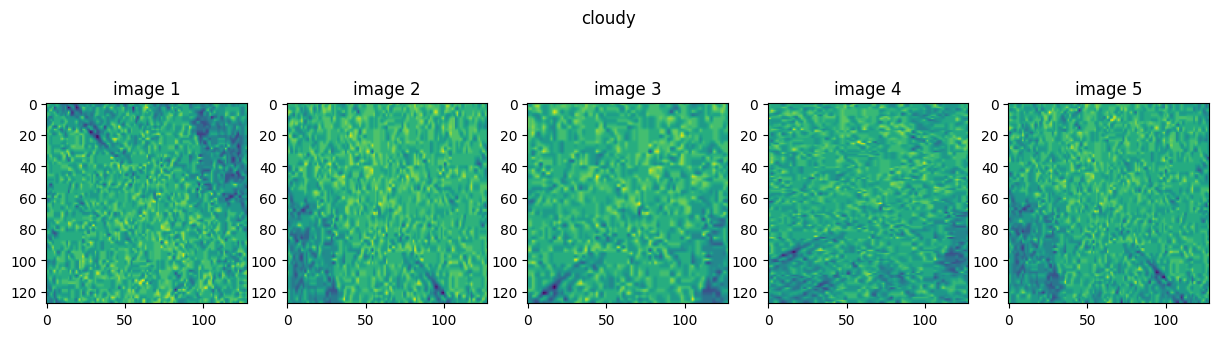

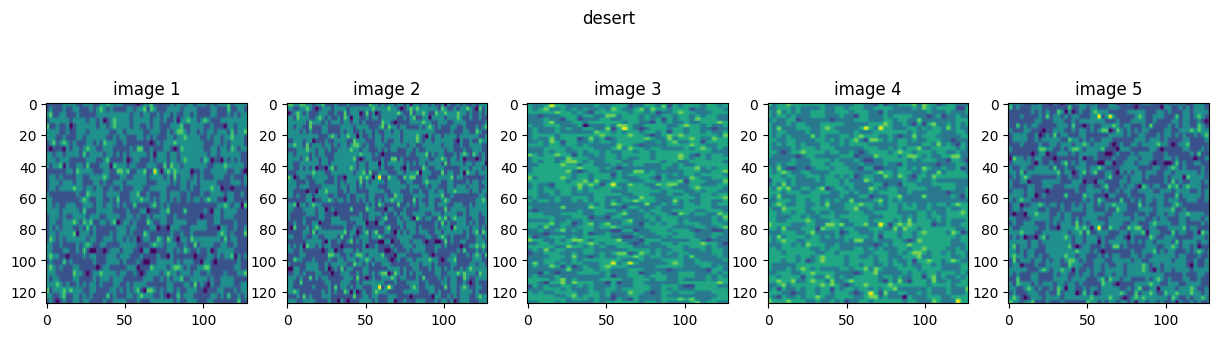

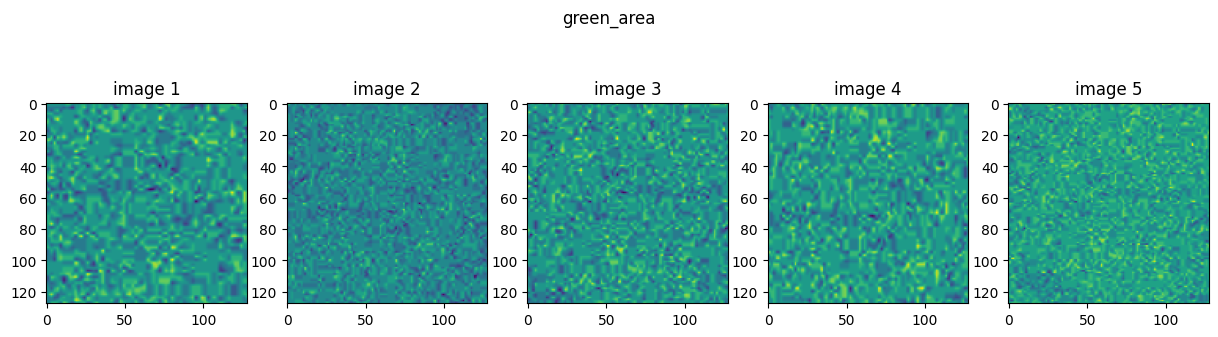

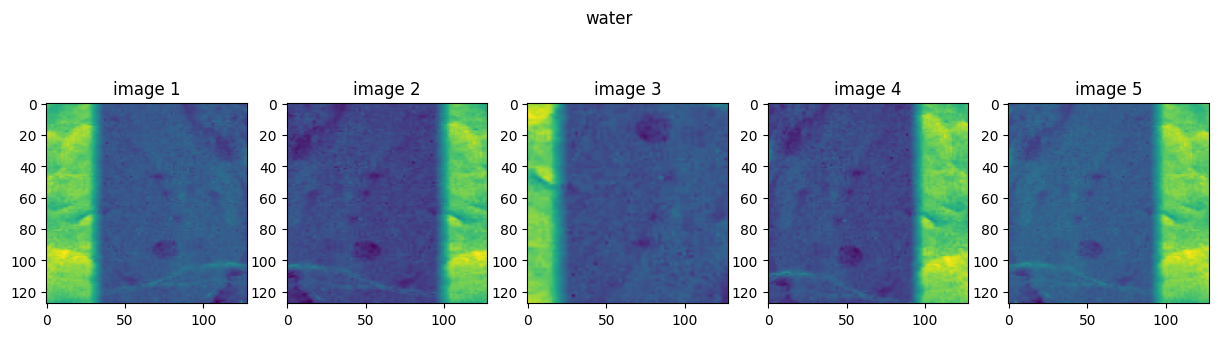

In [38]:
# plot some augmented grayscale images
img_gen_grayscales_dict = {}
img_pos = 0
for i, batch_name in enumerate(img_train_gray.class_indices):
    img_gen_grays = []
    for j in range(5):
        img_gen_grays.append(img_train_gray[0][0][img_pos])

    img_gen_grayscales_dict[batch_name] = img_gen_grays
    img_pos+=5
    
# plot 5 augmented grayscale images per class
show_subplot_img(5, (15, 4), img_gen_grayscales_dict)

### RGB

In [39]:
img_train_rgb, img_val_rgb, img_test_rgb = generate_img_generators(
    train_val_img_datagen,
    test_img_datagen,
    "rgb",
    64
)

Found 4548 validated image filenames belonging to 4 classes.
Found 802 validated image filenames belonging to 4 classes.
Found 281 validated image filenames belonging to 4 classes.


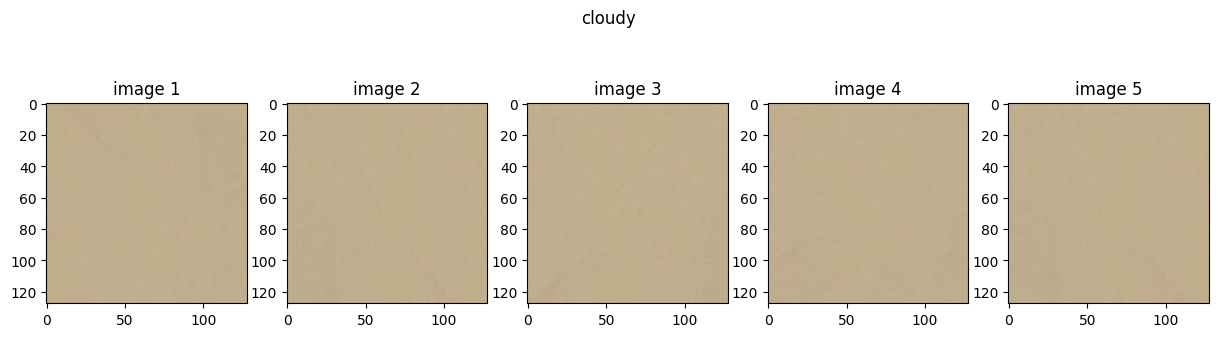

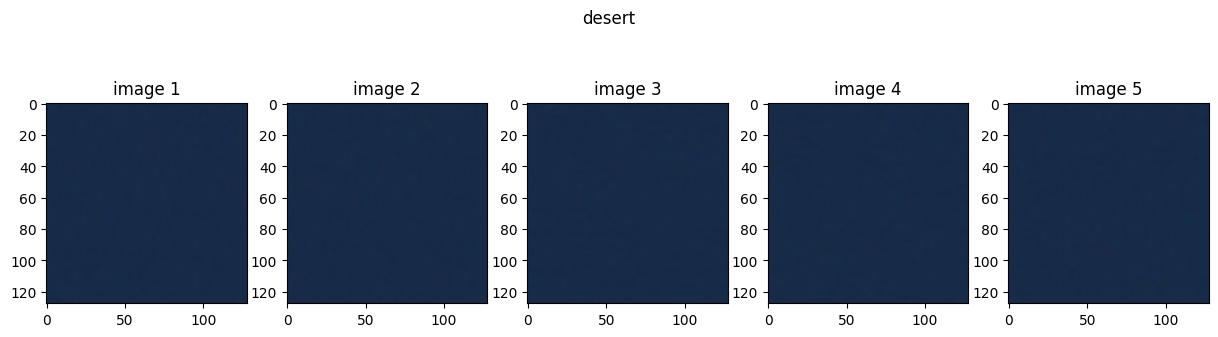

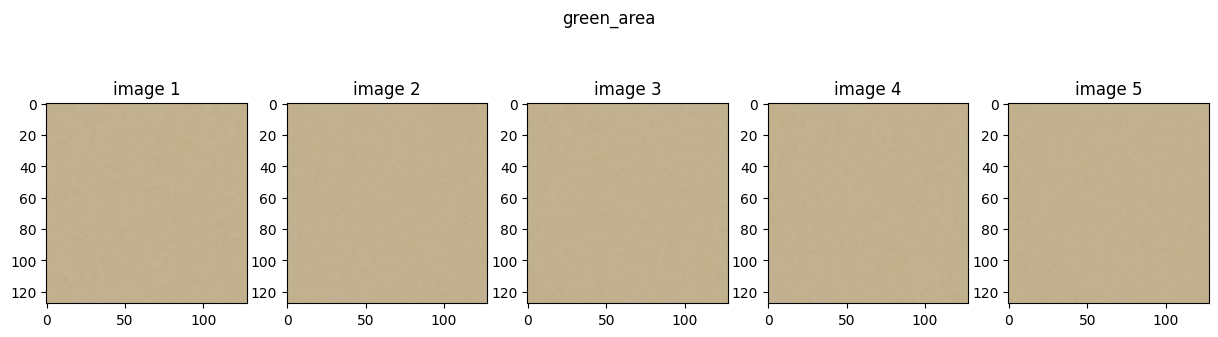

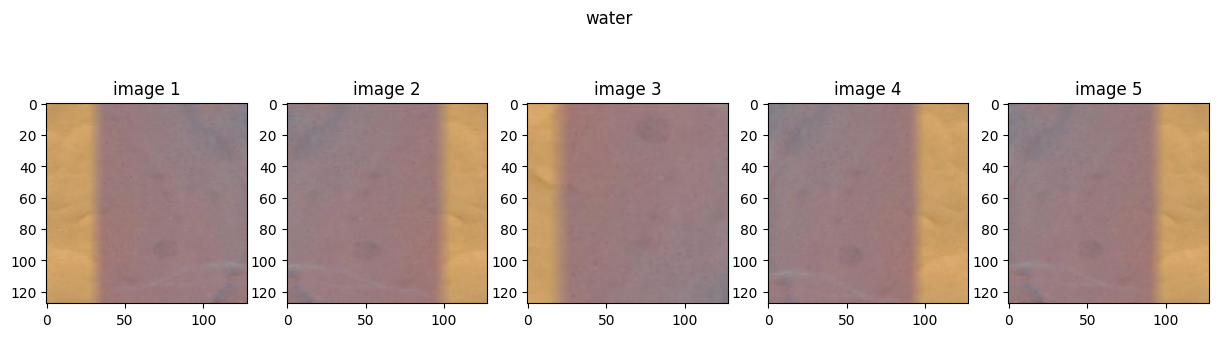

In [40]:
# plot some augmented rgb images
img_gen_rgbs_dict = {}
img_pos = 0
for i, batch_name in enumerate(img_train_rgb.class_indices):
    img_gen_rgbs = []
    for j in range(5):
        img_gen_rgbs.append(img_train_rgb[0][0][img_pos])

    img_gen_rgbs_dict[batch_name] = img_gen_rgbs
    img_pos+=5
    
# plot 5 augmented rgb images per class
show_subplot_img(5, (15, 4), img_gen_rgbs_dict)

> Number of images for training, validation, and test are 4,548; 802; and 281 respectively for both rgb and grayscale images

# Modelling

In [41]:
def get_model_history(
    model: object,
    loss_function: object,
    optimizer: object,
    metrics: list,
    train_data: DataFrameIterator,
    val_data: DataFrameIterator,
    epochs: int,
    callbacks: list=None
)->pd.DataFrame:
    """
    Get history of model training process as dataframe.

    This function process end-to-end training process in the following steps:
    1. compile
    2. fitting
    3. return the training history as dataframe
    
        params:
            model (object): model that hasn't been fitted
            loss_function (object): loss function used when compiling the model
            optimizer (object): optimezer function used when compiling the model
            metrics (list): list of evaluation metrics
            train_data (DataFrameIterator): data train from DataImageGenerator
            val_data (DataFrameIterator): data validation from DataImageGenerator
            epochs (int): number of epochs for model fitting process
            callbacks (list): list of callback functions to call in the model fitting process [default=None]

        return:
            trining history of the model (pd.DataFrame)
    """

    model.compile(
        loss=loss_function, 
        optimizer=optimizer, 
        metrics=metrics
    )

    history = model.fit(
        train_data, 
        epochs=epochs, 
        validation_data=val_data, 
        # print model's training progress
        verbose=1,
        callbacks=callbacks
    )

    return pd.DataFrame(history.history)

In [42]:
def plot_model_history(df: pd.DataFrame, model_name: str)->None:
    """
    Plot model training history to show accuracy and loss

        param:
            df (pd.DataFrame) -> data source that contains accuracy and loss on train and val sets
            model_name (str): the model's name for plot title

        return: None
    """

    # plot accuracy on train and val set
    df[["accuracy", "val_accuracy"]].plot()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy on Train and Val set on {}".format(model_name))
    plt.show()
    
    # plot loss on train and val set
    df[["loss", "val_loss"]].plot()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss on Train and Val set on {}".format(model_name))
    plt.show()

In [43]:
def print_model_evaluation(model: object, test_data: DataFrameIterator)->None:
    """
    Print :model evaluation on :test_data
    
        params:
            model (object): fitted model
            test_data(DataFrameIterator): image generator that contains images of test set
    
        return: None
    """
    pred_res = model.predict(test_data, verbose=False)
    pred_res = np.argmax(pred_res, axis=1)
    
    print("accuracy: {}".format(accuracy_score(test_data.classes, pred_res).round(2)))
    print("\nclassification report")
    print(classification_report(test_data.classes, pred_res, target_names=test_data.class_indices))

In [44]:
def get_early_stopping(
    patience: int=5,
    monitor: str="val_accuracy",
    mode: str="max",
    start_from_epoch: int=10,
    verbose: int=1,
    restore_best_weights=True
)->EarlyStopping:
    """
    Return early stopping that can only be used for callback function in model training process.
    Early stopping will terminate model training process based on defined parameters
    
        params:
            patience (int): number of epochs with no improvement after which training will be stopped [default=5]
            monitor (str): quantity to be monitored [default='val_accuracy']
            mode (str): configure when early function called during trainig process [default='max']
                - 'max': stop when the quantity monitored has stopped increasing
            start_from_epoch (int): number of epochs to wait before starting to monitor improvement [default=10]
            verbose (int): whether to print a notification when early stopping executed
            restore_best_weights (bool): whether to restore model weights from the epoch with the best value of the monitored quantity [default=True]
            
        return: `EarlyStopping`
    """
    
    return EarlyStopping(
            patience=patience,
            monitor='val_accuracy',
            mode="max",
            start_from_epoch=10,
            verbose=1,
            restore_best_weights=restore_best_weights
        )

## Model 1

### Training

For the first model, I will try this configurations:
- layers:
    - convolution2d
        - filter: 128
        - activation: relu
        - pool size: (2, 2) -> small pool size to maintain image's overall information
        - strides: (2, 2) ->  small stride size to maintain image's overall information
    - avg pooling 2d
        - strides: (2, 2) ->  small stride size to maintain image's overall information
        - padding: same -> mantaining pixel on each image's edges, since some images are having important object for differentiate image's characteristics on some edges
    - convolution 2d
        - pool size: (2, 2) -> small pool size to maintain image's overall information
        - strides: (2, 2) ->  small stride size to maintain image's overall information
        - filter: 258
        - activation: relu
    - flatten -> convert multidimensional data into one dimensional data, so it can be feeded to dense layer
    - dense
        - activation: relu
        - units: 512
    - dense (output)
        - activation: softmax -> for multi class classification
        - units: 4 -> to identify 4 classes
- optimizer: adam
- metrics: accuracy -> stated in objective
- epochs: 20 -> try high epoch to get the best result, since I implemented early stopping
- callback: early stopping
    - patience: 5 -> high patience so that the model won't miss global optima
    - monitor: val accuracy
    - mode: max -> stop the training process if the accuracy on validation data hasn't increasing by 10 tries
- loss function: categorical crossentrophy -> for multi class classification

- The value of filter and units on convolution and dense layer are increasing to get better result on accuracy [reference](https://www.quora.com/How-does-increasing-filter-size-improve-the-accuracy-of-a-convolutional-neural-network-CNN#:~:text=Increasing%20the%20filter%20size%20in,make%20predictions%20about%20the%20data.)

### Gray Scale

In [45]:
model1_gray = Sequential([
    Input((128, 128, 1)),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu"
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model1_gray")

model1_gray.summary()

Model: "model1_gray"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 128)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,688,964 (128.51 MB)

 Trainable params: 33,688,964 (128.51 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
%%time
history1_gray = get_model_history(
    model1_gray,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.001),
    ["accuracy"],
    img_train_gray,
    img_val_gray,
    20,
    callbacks=[get_early_stopping()]
)

history1_gray

Epoch 1/20


I0000 00:00:1728032432.792901      69 service.cc:145] XLA service 0x7e38e00070d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728032432.792979      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 3/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.3125 - loss: 1.8804

I0000 00:00:1728032435.616910      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.4628 - loss: 1.2568 - val_accuracy: 0.9850 - val_loss: 0.6026
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.6130 - loss: 0.7081 - val_accuracy: 0.0823 - val_loss: 1.0730
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.6779 - loss: 0.6478 - val_accuracy: 0.0998 - val_loss: 1.1903
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.6857 - loss: 0.6322 - val_accuracy: 0.0973 - val_loss: 0.9506
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.6905 - loss: 0.6325 - val_accuracy: 0.0387 - val_loss: 1.0923
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.6707 - loss: 0.6370 - val_accuracy: 0.0037 - val_loss: 1.5339
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.6772 - loss: 0.6608 - val_accuracy: 0.0025 - val_loss: 1.2953
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.7011 - loss: 0.6155 - val_accuracy: 0.020

accuracy      loss  val_accuracy  val_loss
0   0.547933  0.953087      0.985037  0.602620
1   0.649956  0.680866      0.082294  1.073035
2   0.683597  0.644888      0.099751  1.190258
3   0.682278  0.642033      0.097257  0.950591
4   0.687115  0.635549      0.038653  1.092343
5   0.671064  0.636731      0.003741  1.533899
6   0.690193  0.636966      0.002494  1.295285
7   0.701407  0.612484      0.019950  1.053226
8   0.704925  0.612874      0.043641  1.142933
9   0.702726  0.613782      0.077307  1.207168
10  0.702067  0.613882      0.473815  0.813405
11  0.704485  0.606433      0.102244  1.102230
12  0.687115  0.627554      0.036160  1.418951
13  0.708663  0.607645      0.314214  0.912267
14  0.704485  0.609199      0.133416  1.329642
15  0.706245  0.621809      0.054863  1.417461

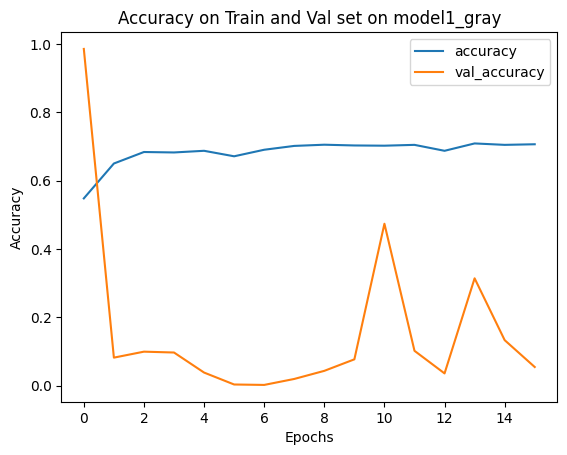

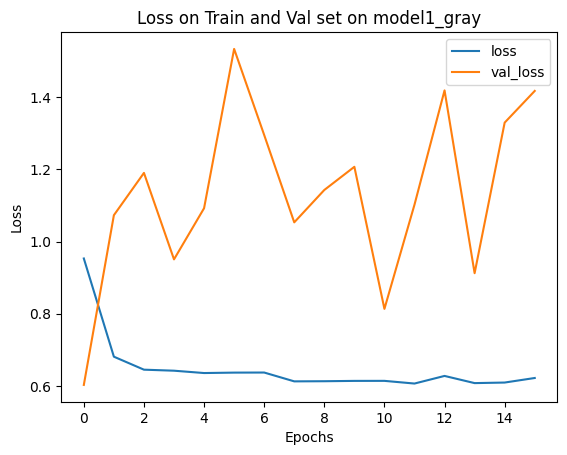

In [47]:
plot_model_history(history1_gray, model1_gray.name)

- The model trained using grayscaled images has overfitting problem
- This model were able to learn pretty well on training set, but its performance on validation set is much worse

#### Evaluation

In [48]:
print_model_evaluation(model1_gray, img_test_gray)

accuracy: 0.6

classification report
              precision    recall  f1-score   support

      cloudy       0.46      0.41      0.43        75
      desert       0.32      0.32      0.32        56
  green_area       0.74      0.89      0.81        75
       water       0.79      0.69      0.74        75

    accuracy                           0.60       281
   macro avg       0.58      0.58      0.57       281
weighted avg       0.59      0.60      0.59       281



- This model only able to generate 66% accuracy, which means this model is not reliable to be used for classifying images.

### RGB

In [49]:
model1 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu"
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model1")

model1.summary()

Model: "model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,689,988 (128.52 MB)

 Trainable params: 33,689,988 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
%%time
history_model1 = get_model_history(
    model1,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.001),
    ["accuracy"],
    img_train_rgb,
    img_val_rgb,
    20,
   callbacks=[get_early_stopping()]
)

history_model1

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 331ms/step - accuracy: 0.5912 - loss: 1.0507 - val_accuracy: 0.8579 - val_loss: 0.4154
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 317ms/step - accuracy: 0.8420 - loss: 0.3748 - val_accuracy: 0.7556 - val_loss: 0.6425
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 309ms/step - accuracy: 0.8597 - loss: 0.3496 - val_accuracy: 0.7980 - val_loss: 0.5469
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 319ms/step - accuracy: 0.8686 - loss: 0.3203 - val_accuracy: 0.7980 - val_loss: 0.5827
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 319ms/step - accuracy: 0.8813 - loss: 0.2982 - val_accuracy: 0.8155 - val_loss: 0.5074
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 314ms/step - accuracy: 0.8825 - loss: 0.2866 - val_accuracy: 0.8579 - val_loss: 0.4012
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 305ms/step - accuracy: 0.8851 - loss: 0.2703 - val_accuracy: 0.9027 - val_loss: 0.2694
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 305ms/step - accuracy: 0.8864 - loss: 0.2749 - val_accu

accuracy      loss  val_accuracy  val_loss
0   0.714600  0.654087      0.857855  0.415437
1   0.845646  0.367154      0.755611  0.642460
2   0.857740  0.346180      0.798005  0.546901
3   0.874011  0.304845      0.798005  0.582743
4   0.881926  0.291589      0.815461  0.507402
5   0.887643  0.288264      0.857855  0.401208
6   0.886544  0.264393      0.902743  0.269388
7   0.880827  0.282272      0.892768  0.345554
8   0.899956  0.254096      0.872818  0.423435
9   0.871372  0.288705      0.846633  0.568914
10  0.883245  0.276214      0.920200  0.225474
11  0.905233  0.235555      0.926434  0.201125
12  0.885884  0.279351      0.885287  0.336390
13  0.906113  0.224866      0.896509  0.366176
14  0.900836  0.235817      0.887781  0.276129
15  0.891601  0.251239      0.864090  0.447887
16  0.898857  0.243603      0.896509  0.240981

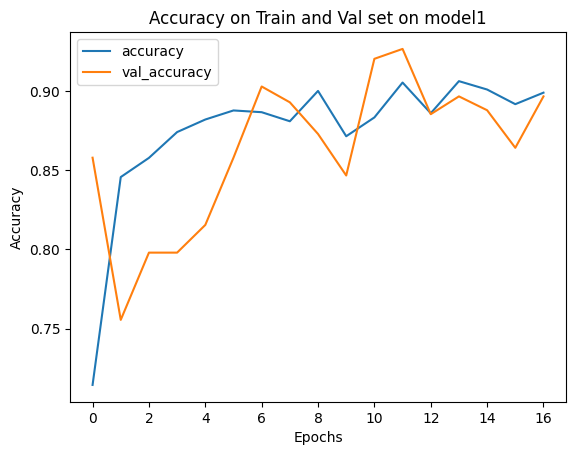

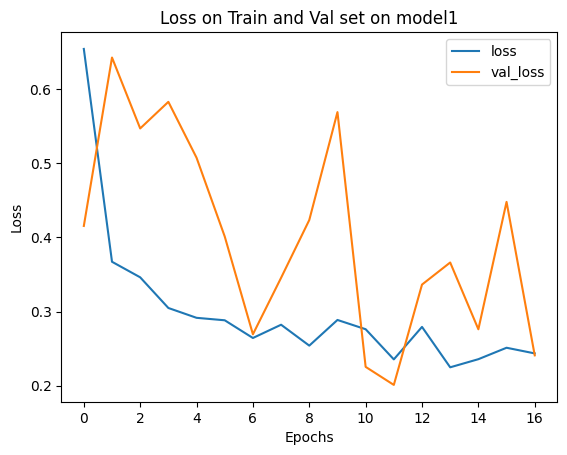

In [51]:
plot_model_history(history_model1, model1.name)

- This model able to generate accuracy on train and validation set by 92% and 87% respectively
- In addition, the error scores on train and validation sets are 20% and 48%
- Therefore, this model is overfitted


- This model also got volatiled evaluations for both validation accuracy and loss.
- This [reference](https://stackoverflow.com/questions/61287322/validation-loss-sometimes-spiking) asserted that **small number of validation data could cause volatility on training and validation set.**
- Since there's only 802 validation data for 4 classes, that statement might be the case.

<u>Concern:</u>
- Although the model's performance on accuracy scores are decent, it's actually overfitted.


- The number of validation set is pretty small.
- This could led into biased result. Since there's only small amount of variance on validation set, the model might remember the pattern in validation set.
- Therefore, I will increase number of validation set in hyperparameter tuning 1.

#### Evaluation

In [52]:
print_model_evaluation(model1, img_test_rgb)

accuracy: 0.95

classification report
              precision    recall  f1-score   support

      cloudy       0.99      0.95      0.97        75
      desert       0.93      0.98      0.96        56
  green_area       0.92      0.97      0.95        75
       water       0.97      0.92      0.95        75

    accuracy                           0.95       281
   macro avg       0.95      0.96      0.95       281
weighted avg       0.95      0.95      0.95       281



- This model was able to achieve an exceptional 95% accuracy by simply changing the training images from grayscale to RGB.

## Hyperparameter Tuning 1

In this section, I will increase the proportion of validation set from 15% to 20%

In [53]:
train_val_img_datagen_tuned1, test_img_datagen_tuned1 = create_img_generators(validation_split=0.2)

In [54]:
img_train_rgb_tuned1, img_val_rgb_tuned1, img_test_rgb_tuned1 = generate_img_generators(
    train_val_img_datagen_tuned1,
    test_img_datagen_tuned1,
    "rgb",
    64
)

Found 4280 validated image filenames belonging to 4 classes.
Found 1070 validated image filenames belonging to 4 classes.
Found 281 validated image filenames belonging to 4 classes.


### Training

In [55]:
model_tuned1 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2),
        kernel_initializer = initializers.HeNormal(seed=9)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2),
        kernel_initializer = initializers.HeNormal(seed=9)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu",
        kernel_initializer = initializers.HeNormal(seed=9)
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model_tuned1")

model_tuned1.summary()

Model: "model_tuned1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,689,988 (128.52 MB)

 Trainable params: 33,689,988 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
%%time
history_model_tuned1 = get_model_history(
    model_tuned1,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    ["accuracy"],
    img_train_rgb_tuned1,
    img_val_rgb_tuned1,
    20,
    callbacks=[get_early_stopping()]
)

history_model_tuned1

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 29s 369ms/step - accuracy: 0.6443 - loss: 1.0636 - val_accuracy: 0.8879 - val_loss: 0.2839
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 342ms/step - accuracy: 0.8328 - loss: 0.4036 - val_accuracy: 0.8234 - val_loss: 0.5472
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 341ms/step - accuracy: 0.8716 - loss: 0.3407 - val_accuracy: 0.6374 - val_loss: 0.9431
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 349ms/step - accuracy: 0.8327 - loss: 0.3919 - val_accuracy: 0.9234 - val_loss: 0.2011
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 342ms/step - accuracy: 0.8372 - loss: 0.3946 - val_accuracy: 0.7308 - val_loss: 0.7749
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 341ms/step - accuracy: 0.8604 - loss: 0.3358 - val_accuracy: 0.7972 - val_loss: 0.6875
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 347ms/step - accuracy: 0.8704 - loss: 0.3169 - val_accuracy: 0.7084 - val_loss: 0.8867
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 336ms/step - accuracy: 0.8726 - loss: 0.3251 - val_accu

accuracy      loss  val_accuracy  val_loss
0   0.718692  0.665053      0.887850  0.283932
1   0.842757  0.386097      0.823364  0.547150
2   0.861916  0.352240      0.637383  0.943094
3   0.840654  0.375083      0.923364  0.201073
4   0.846963  0.366571      0.730841  0.774947
5   0.859112  0.337749      0.797196  0.687533
6   0.864486  0.322976      0.708411  0.886702
7   0.869626  0.325665      0.807477  0.657697
8   0.878271  0.301429      0.861682  0.397850
9   0.869860  0.309377      0.863551  0.440194
10  0.885047  0.280751      0.883178  0.365515
11  0.882243  0.272658      0.887850  0.329289
12  0.892290  0.258184      0.894393  0.271684
13  0.892523  0.256605      0.900000  0.257191
14  0.899766  0.250601      0.869159  0.441815
15  0.892056  0.263541      0.849533  0.494125
16  0.903271  0.236077      0.713084  0.867755
17  0.904206  0.228153      0.875701  0.352734
18  0.907944  0.219945      0.896262  0.277626

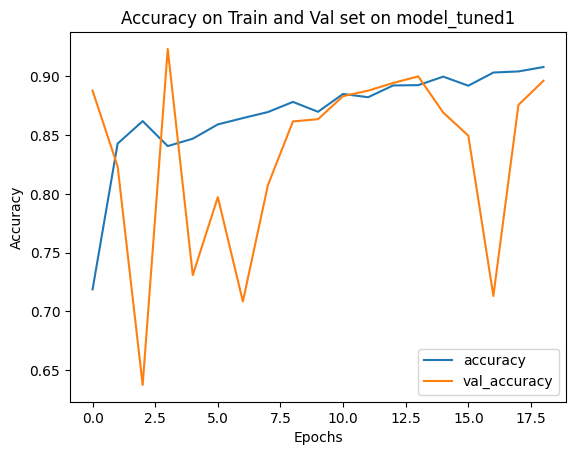

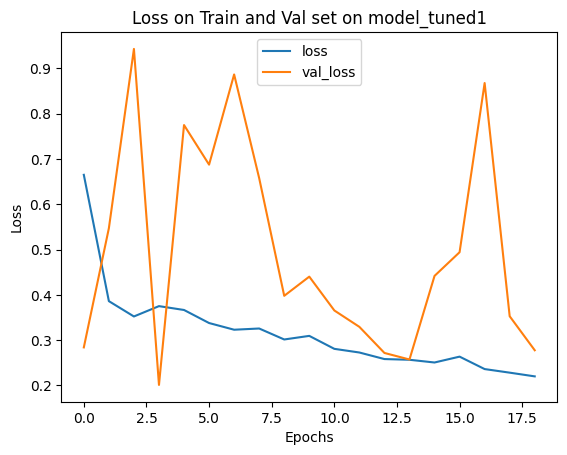

In [57]:
plot_model_history(history_model_tuned1, model_tuned1.name)

- The tuned model was able to generate 91% and 90% accuracy on train and validation sets respectively.
- But the error on train and validation are 22% and 30% respectively.
- Thus, this model is overfitted to train set

### Evaluation

In [58]:
print_model_evaluation(model_tuned1, img_test_rgb_tuned1)

accuracy: 0.91

classification report
              precision    recall  f1-score   support

      cloudy       0.99      0.93      0.96        75
      desert       0.93      0.98      0.96        56
  green_area       0.95      0.77      0.85        75
       water       0.80      0.96      0.87        75

    accuracy                           0.91       281
   macro avg       0.92      0.91      0.91       281
weighted avg       0.92      0.91      0.91       281



- This model performed worse than model 1 on train and validation sets


- Volatilities on validation accuracy and loss kind are somewhat reduced a little
- But, the problem remained persist.
- In conclusion, increasing number of validation data does reduced the volatility, but not significant.

## Hyperparameter Tuning 2

In this part, I will increase the batch size from 64 to 128 using tuned image generator

In [59]:
img_train_rgb_tuned2, img_val_rgb_tuned2, img_test_rgb_tuned2 = generate_img_generators(
    train_val_img_datagen_tuned1,
    test_img_datagen_tuned1,
    "rgb",
    128
)

Found 4280 validated image filenames belonging to 4 classes.
Found 1070 validated image filenames belonging to 4 classes.
Found 281 validated image filenames belonging to 4 classes.


In [60]:
model_tuned2 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu",
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model_tuned2")

model_tuned2.summary()

Model: "model_tuned2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,689,988 (128.52 MB)

 Trainable params: 33,689,988 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
%%time
history_model_tuned2 = get_model_history(
    model_tuned2,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    ["accuracy"],
    img_train_rgb_tuned2,
    img_val_rgb_tuned2,
    20,
    callbacks=[get_early_stopping()]
)

history_model_tuned2

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 632ms/step - accuracy: 0.5093 - loss: 0.9873 - val_accuracy: 0.5570 - val_loss: 0.8616
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 601ms/step - accuracy: 0.8211 - loss: 0.5017 - val_accuracy: 0.7598 - val_loss: 0.7122
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 612ms/step - accuracy: 0.8504 - loss: 0.4250 - val_accuracy: 0.8542 - val_loss: 0.4440
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 610ms/step - accuracy: 0.8622 - loss: 0.3868 - val_accuracy: 0.8710 - val_loss: 0.3720
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 606ms/step - accuracy: 0.8662 - loss: 0.3480 - val_accuracy: 0.7766 - val_loss: 0.6939
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 625ms/step - accuracy: 0.8653 - loss: 0.3448 - val_accuracy: 0.8056 - val_loss: 0.6031
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 601ms/step - accuracy: 0.8631 - loss: 0.3310 - val_accuracy: 0.8421 - val_loss: 0.4554
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 601ms/step - accuracy: 0.8762 - loss: 0.3115 - val_accu

accuracy      loss  val_accuracy  val_loss
0   0.611916  0.764237      0.557009  0.861619
1   0.817523  0.478679      0.759813  0.712229
2   0.847196  0.418637      0.854206  0.444019
3   0.859813  0.372090      0.871028  0.372030
4   0.866589  0.342116      0.776636  0.693931
5   0.864486  0.338051      0.805607  0.603055
6   0.855374  0.338152      0.842056  0.455438
7   0.879439  0.303417      0.815888  0.555793
8   0.883178  0.290374      0.794393  0.616314
9   0.881776  0.280747      0.818692  0.543543
10  0.885514  0.285013      0.838318  0.462423
11  0.885748  0.280985      0.844860  0.437669
12  0.884579  0.280805      0.768224  0.612648
13  0.894159  0.261992      0.832710  0.489674
14  0.899533  0.253644      0.777570  0.592486
15  0.897196  0.252663      0.860748  0.400358
16  0.896262  0.253134      0.730841  0.732145
17  0.907710  0.236729      0.880374  0.343704
18  0.903037  0.236793      0.823364  0.521221
19  0.902804  0.232064      0.861682  0.414189

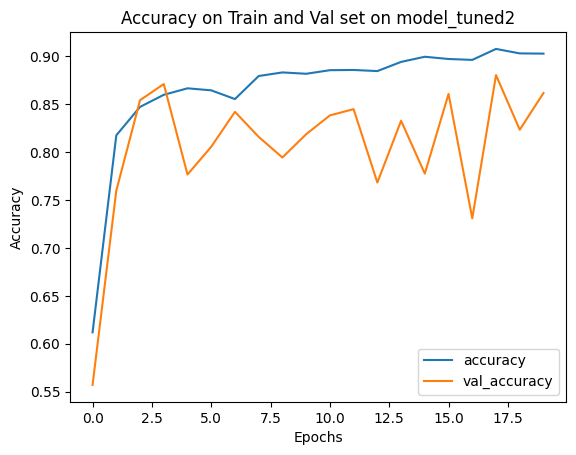

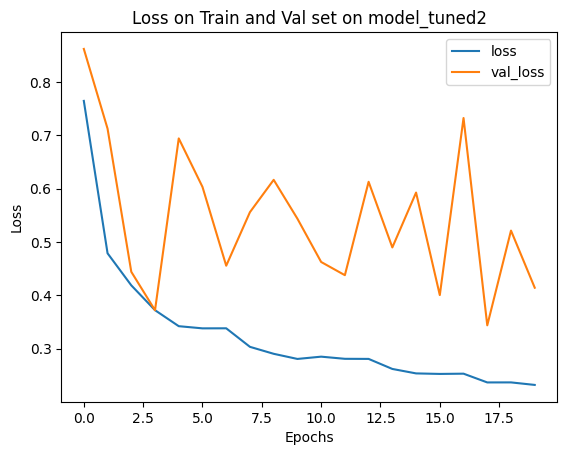

In [62]:
plot_model_history(history_model_tuned2, model_tuned2.name)

In [63]:
history_model_tuned1.iloc[-1]

accuracy        0.907944
loss            0.219945
val_accuracy    0.896262
val_loss        0.277626
Name: 18, dtype: float64

In [64]:
history_model_tuned2.iloc[-1]

accuracy        0.902804
loss            0.232064
val_accuracy    0.861682
val_loss        0.414189
Name: 19, dtype: float64

- This model performed worse than hyper parameter tuned 1 model.
- Increasing the batch size to 128 worsen accuracy and loss scores across training and validation sets.
- This model still overfitted

### Evaluation

In [65]:
print_model_evaluation(model_tuned2, img_test_rgb_tuned2)

accuracy: 0.94

classification report
              precision    recall  f1-score   support

      cloudy       0.99      0.92      0.95        75
      desert       0.93      0.98      0.96        56
  green_area       0.92      0.96      0.94        75
       water       0.93      0.92      0.93        75

    accuracy                           0.94       281
   macro avg       0.94      0.95      0.94       281
weighted avg       0.94      0.94      0.94       281



- Because this model is able to reduce the loss score difference, **I consider it an improvement over Model 1**

- To further improve this model, I will add a dropout layer to address the overfitting problem.

## Hyperparameter Tuning 3

> add dropout layer 40%

[ref](https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network) stated that dropout can applied in various ways:
- after convolution layer: add small dropout layer (0.1<= drop out rate <=0.2)
- after each fully connected layer (dense) before output, initially p=0.5 was commonly used.

Considerations:

>In the original paper that proposed dropout layers, by Hinton (2012), dropout (with p=0.5) was used on each of the fully connected (dense) layers before the output; it was not used on the convolutional layers. This became the most commonly used configuration.

>More recent research has shown some value in applying dropout also to convolutional layers, although at much lower levels: p=0.1 or 0.2. Dropout was used after the activation function of each convolutional layer: CONV->RELU->DROP.

========================================================================

>The original paper proposed dropout layers that were used on each of the fully connected (dense) layers before the output; it was not used on the convolutional layers.

>We must not use dropout layer after convolutional layer as we slide the filter over the width and height of the input image we produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. So as dropout layer neutralizes (makes it zero) random neurons there are chances of loosing very important feature in an image in our training process.

In [66]:
model_tuned3 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu"
    ),
    Dropout(
        rate=0.5,
        seed=9
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model_tuned3")

model_tuned3.summary()

Model: "model_tuned3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,689,988 (128.52 MB)

 Trainable params: 33,689,988 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
%%time
history_model_tuned3 = get_model_history(
    model_tuned3,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    ["accuracy"],
    img_train_rgb_tuned2,
    img_val_rgb_tuned2,
    20,
    callbacks=[get_early_stopping()]
)

history_model_tuned3

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 30s 666ms/step - accuracy: 0.4972 - loss: 1.0536 - val_accuracy: 0.7935 - val_loss: 0.7195
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 602ms/step - accuracy: 0.6699 - loss: 0.5760 - val_accuracy: 0.8626 - val_loss: 0.4713
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 596ms/step - accuracy: 0.7487 - loss: 0.5034 - val_accuracy: 0.8290 - val_loss: 0.5827
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 582ms/step - accuracy: 0.7909 - loss: 0.4578 - val_accuracy: 0.7991 - val_loss: 0.6622
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 592ms/step - accuracy: 0.8175 - loss: 0.4268 - val_accuracy: 0.5813 - val_loss: 1.0459
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 600ms/step - accuracy: 0.8455 - loss: 0.4066 - val_accuracy: 0.8542 - val_loss: 0.4488
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 593ms/step - accuracy: 0.8542 - loss: 0.3607 - val_accuracy: 0.8645 - val_loss: 0.4344
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 603ms/step - accuracy: 0.8557 - loss: 0.3570 - val_accu

accuracy      loss  val_accuracy  val_loss
0   0.579439  0.847453      0.793458  0.719494
1   0.681075  0.559646      0.862617  0.471349
2   0.759112  0.485928      0.828972  0.582697
3   0.802804  0.451070      0.799065  0.662153
4   0.829206  0.419418      0.581308  1.045917
5   0.849533  0.388364      0.854206  0.448760
6   0.852570  0.371184      0.864486  0.434396
7   0.860514  0.347256      0.876635  0.379396
8   0.866589  0.332602      0.857009  0.426211
9   0.871729  0.316588      0.825234  0.575285
10  0.882710  0.310752      0.841121  0.475130
11  0.880607  0.295663      0.843925  0.460275
12  0.882477  0.294122      0.849533  0.443772
13  0.882944  0.292564      0.746729  0.754313
14  0.888318  0.279096      0.800000  0.623905
15  0.890888  0.273799      0.881308  0.361546
16  0.886449  0.275690      0.827103  0.532001
17  0.895093  0.261409      0.805607  0.620017
18  0.887617  0.263149      0.845794  0.475334
19  0.890187  0.263127      0.835514  0.521417

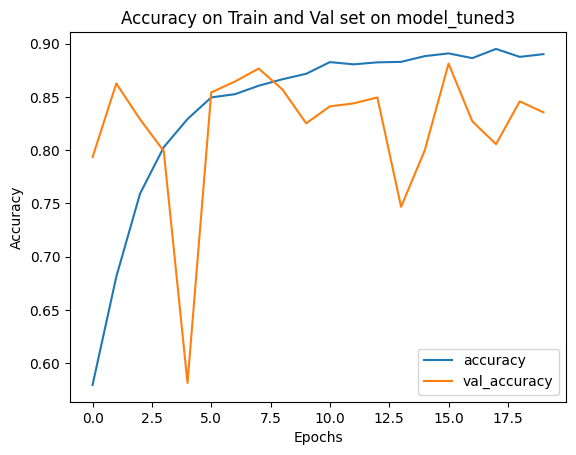

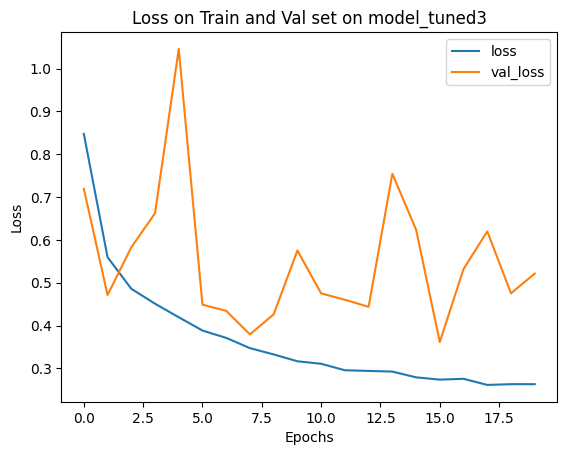

In [68]:
plot_model_history(history_model_tuned3, model_tuned3.name)

In [69]:
history_model_tuned2.iloc[-1]

accuracy        0.902804
loss            0.232064
val_accuracy    0.861682
val_loss        0.414189
Name: 19, dtype: float64

In [70]:
history_model_tuned3.iloc[-1]

accuracy        0.890187
loss            0.263127
val_accuracy    0.835514
val_loss        0.521417
Name: 19, dtype: float64

- Surprisingly, **adding a dropout layer failed to address the overfitting problem.** In fact, it made the validation loss worse.

### Evaluation

In [71]:
print_model_evaluation(model_tuned3, img_test_rgb_tuned2)

accuracy: 0.92

classification report
              precision    recall  f1-score   support

      cloudy       0.99      0.88      0.93        75
      desert       0.93      0.98      0.96        56
  green_area       0.92      0.91      0.91        75
       water       0.85      0.92      0.88        75

    accuracy                           0.92       281
   macro avg       0.92      0.92      0.92       281
weighted avg       0.92      0.92      0.92       281



- Altough this model improved 1% on accuracy, the loss on validation increased more than 0.3. Which means, this model's performance is unstable.
- Therefore hyperparameter tuned model 2 still the best model

## Hyperparameter Tuning 4

In this section, I will improve hyperparameter tuned 2 model by adding kernel initializer

In [72]:
model_tuned4 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2),
        kernel_initializer = initializers.HeNormal(seed=9)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2),
        kernel_initializer = initializers.HeNormal(seed=9)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu",
        kernel_initializer = initializers.HeNormal(seed=9)
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model_tuned4")

model_tuned4.summary()

Model: "model_tuned4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,689,988 (128.52 MB)

 Trainable params: 33,689,988 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
%%time
history_model_tuned4 = get_model_history(
    model_tuned4,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    ["accuracy"],
    img_train_rgb_tuned2,
    img_val_rgb_tuned2,
    20,
    callbacks=[get_early_stopping()]
)

history_model_tuned4

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 30s 694ms/step - accuracy: 0.5460 - loss: 1.3957 - val_accuracy: 0.2187 - val_loss: 1.7154
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 620ms/step - accuracy: 0.8453 - loss: 0.4146 - val_accuracy: 0.8421 - val_loss: 0.5163
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 597ms/step - accuracy: 0.8466 - loss: 0.3745 - val_accuracy: 0.5290 - val_loss: 1.2651
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 631ms/step - accuracy: 0.8637 - loss: 0.3549 - val_accuracy: 0.8944 - val_loss: 0.2693
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 619ms/step - accuracy: 0.8474 - loss: 0.3816 - val_accuracy: 0.8907 - val_loss: 0.2858
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 602ms/step - accuracy: 0.8636 - loss: 0.3425 - val_accuracy: 0.8187 - val_loss: 0.5306
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 598ms/step - accuracy: 0.8640 - loss: 0.3336 - val_accuracy: 0.8794 - val_loss: 0.3308
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 599ms/step - accuracy: 0.8654 - loss: 0.3285 - val_accu

accuracy      loss  val_accuracy  val_loss
0   0.654206  0.901643      0.218692  1.715376
1   0.847196  0.395877      0.842056  0.516281
2   0.838318  0.386171      0.528972  1.265097
3   0.851168  0.362864      0.894393  0.269267
4   0.855140  0.357507      0.890654  0.285804
5   0.865187  0.340034      0.818692  0.530550
6   0.866121  0.331445      0.879439  0.330835
7   0.866121  0.326235      0.736449  0.773505
8   0.865654  0.327204      0.904673  0.203972
9   0.872664  0.316308      0.890654  0.241824
10  0.880841  0.294225      0.799065  0.643895
11  0.885280  0.288237      0.876635  0.372181
12  0.881776  0.275666      0.850467  0.432090
13  0.891122  0.266090      0.757009  0.735924
14  0.888318  0.267733      0.830841  0.567749
15  0.891122  0.261322      0.885981  0.320248
16  0.904439  0.240629      0.865421  0.398225
17  0.903972  0.242389      0.888785  0.333466
18  0.904673  0.242767      0.828037  0.548544
19  0.916355  0.216713      0.892523  0.279723

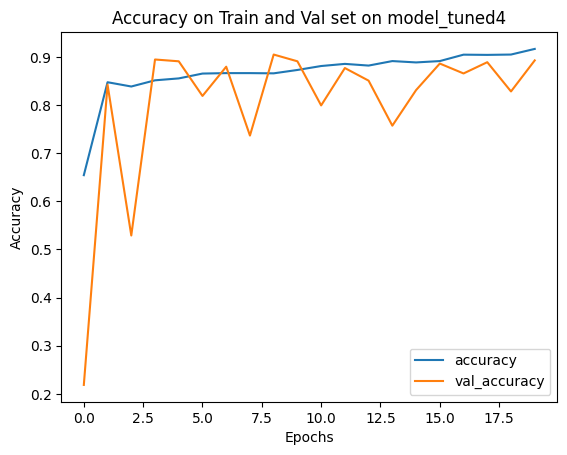

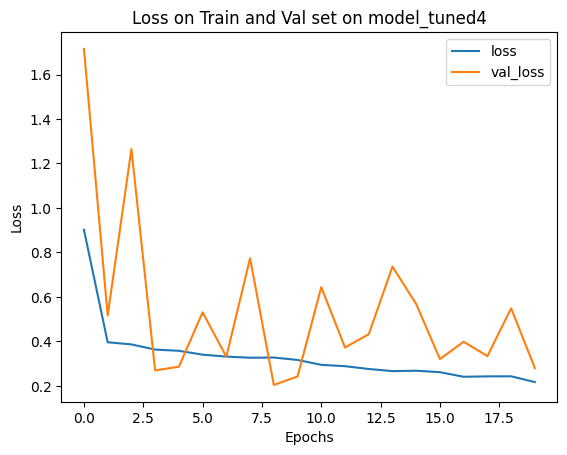

In [74]:
plot_model_history(history_model_tuned4, model_tuned4.name)

In [75]:
history_model_tuned2.iloc[-1]

accuracy        0.902804
loss            0.232064
val_accuracy    0.861682
val_loss        0.414189
Name: 19, dtype: float64

In [76]:
history_model_tuned4.iloc[-1]

accuracy        0.916355
loss            0.216713
val_accuracy    0.892523
val_loss        0.279723
Name: 19, dtype: float64

- Adding kernel initializer to the model's layers actually make the performance worse
- Validation loss of this model increased from 46% to 89%

### Evaluation

In [77]:
print_model_evaluation(model_tuned4, img_test_rgb_tuned2)

accuracy: 0.95

classification report
              precision    recall  f1-score   support

      cloudy       0.99      0.93      0.96        75
      desert       0.93      0.98      0.96        56
  green_area       0.95      0.95      0.95        75
       water       0.93      0.95      0.94        75

    accuracy                           0.95       281
   macro avg       0.95      0.95      0.95       281
weighted avg       0.95      0.95      0.95       281



Accuracy of this model on test data also worse from 93% to 89%

## Hyperparameter Tuning 5

add 2 dropout layers, 1 before flatten and 1 before output layer

In [78]:
model_tuned5 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Dropout(
        rate=0.2,
        seed=9
    ),    
    Flatten(),
    Dense(
        512,
        activation="relu"
    ),
    Dropout(
        rate=0.5,
        seed=9
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model_tuned5")

model_tuned5.summary()

Model: "model_tuned5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,689,988 (128.52 MB)

 Trainable params: 33,689,988 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
%%time
history_model_tuned5 = get_model_history(
    model_tuned5,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    ["accuracy"],
    img_train_rgb_tuned2,
    img_val_rgb_tuned2,
    20,
    callbacks=[get_early_stopping()]
)

history_model_tuned5

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 681ms/step - accuracy: 0.5174 - loss: 0.9655 - val_accuracy: 0.6729 - val_loss: 0.8222
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 604ms/step - accuracy: 0.7014 - loss: 0.5372 - val_accuracy: 0.7411 - val_loss: 0.7517
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 613ms/step - accuracy: 0.7658 - loss: 0.4889 - val_accuracy: 0.7822 - val_loss: 0.6929
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 600ms/step - accuracy: 0.8281 - loss: 0.4237 - val_accuracy: 0.8206 - val_loss: 0.5956
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 612ms/step - accuracy: 0.8409 - loss: 0.3851 - val_accuracy: 0.7103 - val_loss: 0.8600
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 635ms/step - accuracy: 0.8641 - loss: 0.3442 - val_accuracy: 0.8617 - val_loss: 0.4255
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 596ms/step - accuracy: 0.8650 - loss: 0.3392 - val_accuracy: 0.8215 - val_loss: 0.5737
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 595ms/step - accuracy: 0.8613 - loss: 0.3413 - val_accu

accuracy      loss  val_accuracy  val_loss
0   0.610047  0.756168      0.672897  0.822232
1   0.717757  0.525709      0.741121  0.751738
2   0.789019  0.461005      0.782243  0.692859
3   0.829439  0.412629      0.820561  0.595627
4   0.845093  0.379888      0.710280  0.859975
5   0.859112  0.347533      0.861682  0.425541
6   0.856308  0.348743      0.821495  0.573700
7   0.861916  0.339459      0.826168  0.559010
8   0.871028  0.319445      0.852336  0.430595
9   0.875935  0.310091      0.849533  0.444096
10  0.875000  0.300794      0.928037  0.205064
11  0.883178  0.287954      0.834579  0.546840
12  0.873365  0.298162      0.843925  0.491597
13  0.872897  0.297380      0.852336  0.435179
14  0.881542  0.294241      0.767290  0.742473
15  0.892991  0.265073      0.868224  0.401365

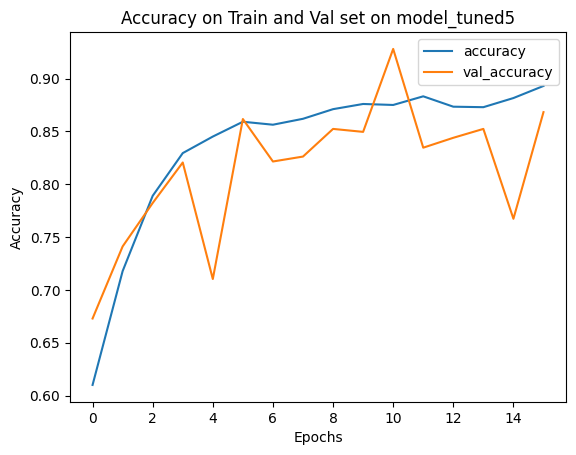

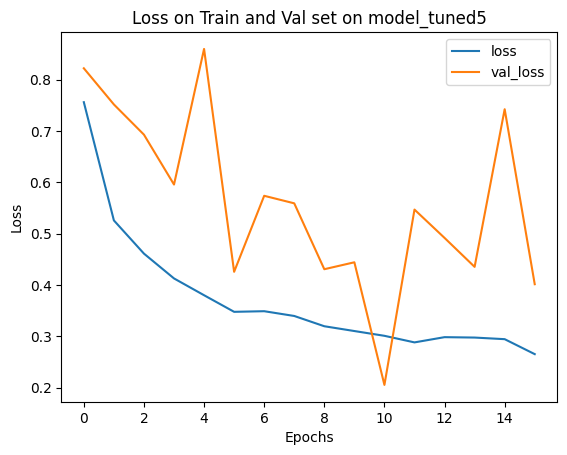

In [80]:
plot_model_history(history_model_tuned5, model_tuned5.name)

In [81]:
history_model_tuned4.iloc[-1]

accuracy        0.916355
loss            0.216713
val_accuracy    0.892523
val_loss        0.279723
Name: 19, dtype: float64

In [82]:
history_model_tuned5.iloc[-1]

accuracy        0.892991
loss            0.265073
val_accuracy    0.868224
val_loss        0.401365
Name: 15, dtype: float64

### Evaluation

In [83]:
print_model_evaluation(model_tuned5, img_test_rgb_tuned2)

accuracy: 0.93

classification report
              precision    recall  f1-score   support

      cloudy       0.91      0.93      0.92        75
      desert       0.92      0.88      0.90        56
  green_area       0.96      0.92      0.94        75
       water       0.91      0.96      0.94        75

    accuracy                           0.93       281
   macro avg       0.93      0.92      0.92       281
weighted avg       0.93      0.93      0.93       281



# Model Mislcassification Analysis

In [84]:
img_test_df["label"].value_counts()

label
cloudy        75
green_area    75
water         75
desert        56
Name: count, dtype: int64

In [85]:
pred_res = model_tuned2.predict(img_test_rgb_tuned2)
pred_res = np.argmax(pred_res, axis=1)
pred_res

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [86]:
# create a dataframe to contain true and pred label
img_test_analysis = pd.DataFrame()
img_test_analysis["true_label"] = img_test_rgb_tuned2.classes
img_test_analysis["pred_label"] = pred_res

In [87]:
img_test_analysis

true_label  pred_label
0             0           0
1             0           0
2             0           0
3             0           0
4             0           0
..          ...         ...
276           3           3
277           3           3
278           3           3
279           3           3
280           3           3

[281 rows x 2 columns]

In [88]:
# filter miss-classified images
miss_pred_df = img_test_analysis[
    img_test_analysis["true_label"]!=img_test_analysis["pred_label"]
]
miss_pred_df

true_label  pred_label
18            0           1
27            0           3
39            0           1
40            0           1
54            0           3
70            0           1
118           1           0
139           2           3
190           2           3
197           2           3
208           3           2
213           3           2
221           3           2
230           3           2
239           3           2
270           3           2

In [89]:
# filter image that miss-classifed as cloudy
miss_classified_as_cloudy = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==0].index]
miss_classified_as_cloudy

label                                      path
2076  desert  /kaggle/input/data/desert/desert(87).jpg

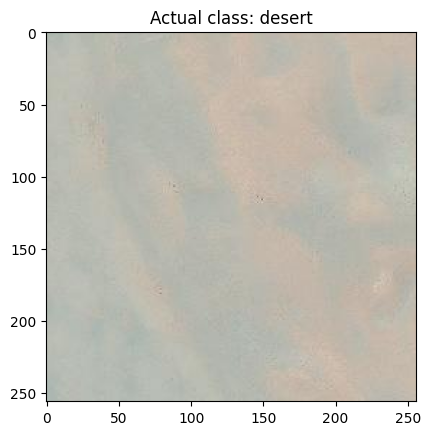

In [90]:
# plot image that miss-classifed as cloudy
for _, v in miss_classified_as_cloudy.iterrows():
    plt.imshow(
        read_img_rgb(v["path"])
    )
    plt.title("Actual class: {}".format(v["label"]))
    plt.show()

- Turns out that this dessert image actually has similar color characteristic with cloudy.

- Adding more images of desert that look similar as cloudy could resolve this misclassification issue

In [91]:
# filter image that miss-classifed as desert
miss_classified_as_desert = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==1].index]
miss_classified_as_desert

label                                       path
775   cloudy  /kaggle/input/data/cloudy/train_40320.jpg
846   cloudy   /kaggle/input/data/cloudy/train_7323.jpg
1381  cloudy   /kaggle/input/data/cloudy/train_1500.jpg
1111  cloudy  /kaggle/input/data/cloudy/train_28686.jpg

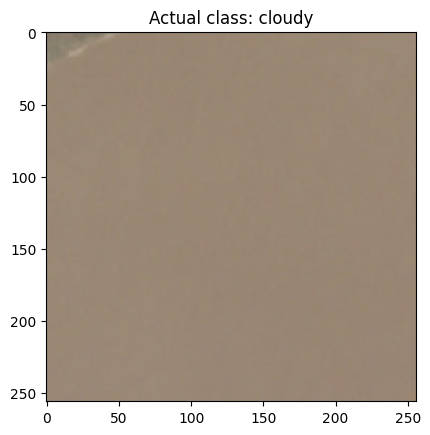

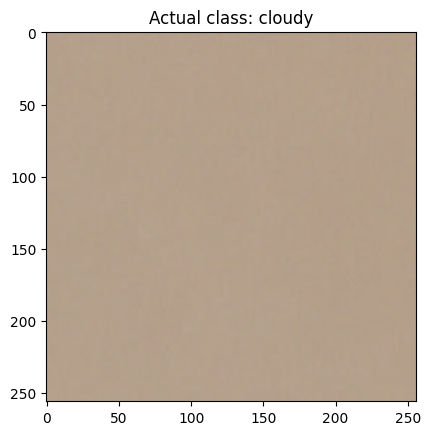

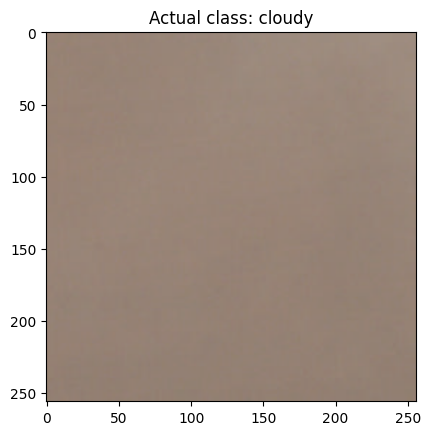

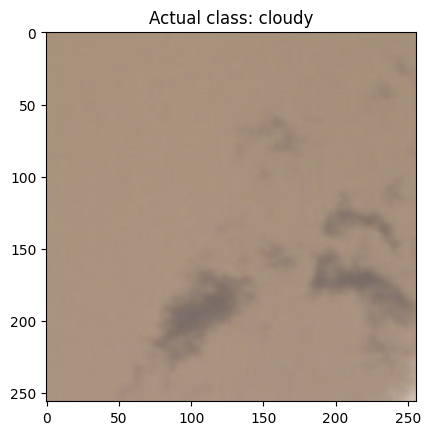

In [92]:
# plot image that miss-classifed as desert
for _, v in miss_classified_as_desert.iterrows():
    plt.imshow(
        read_img_rgb(v["path"])
    )
    plt.title("Actual class: {}".format(v["label"]))
    plt.show()

- All of these images are borwn, which make them extremely similiar to a desert image.
- This might happend because the dataset contains small number of cloudy images that look similar to a desert image. Hence, the model conclude that brown images are desert.
- Adding more cloudy images with brown color could fix this issuse.

In [93]:
# filter image that miss-classifed as green area
miss_classified_as_green_area = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==2].index]
miss_classified_as_green_area

label                                       path
5123  water  /kaggle/input/data/water/SeaLake_2738.jpg
5552  water   /kaggle/input/data/water/SeaLake_741.jpg
5243  water   /kaggle/input/data/water/SeaLake_905.jpg
4564  water   /kaggle/input/data/water/SeaLake_785.jpg
4525  water  /kaggle/input/data/water/SeaLake_2624.jpg
5610  water  /kaggle/input/data/water/SeaLake_1507.jpg

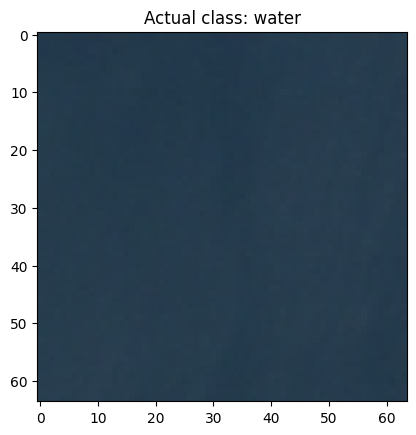

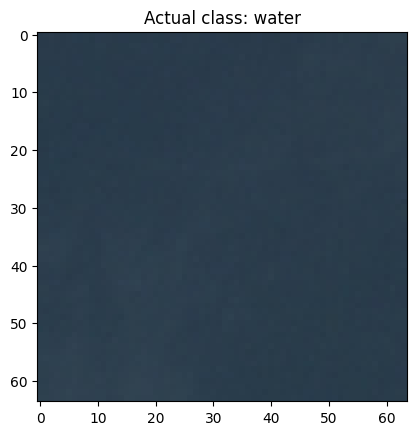

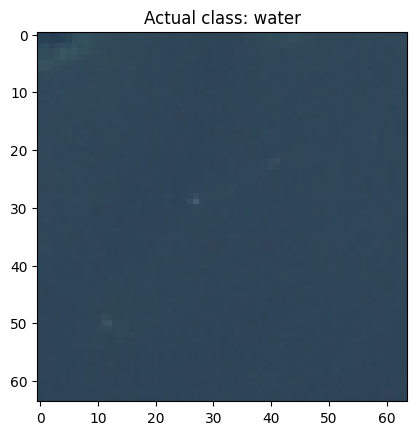

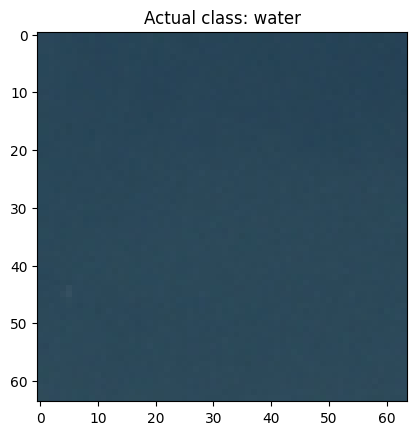

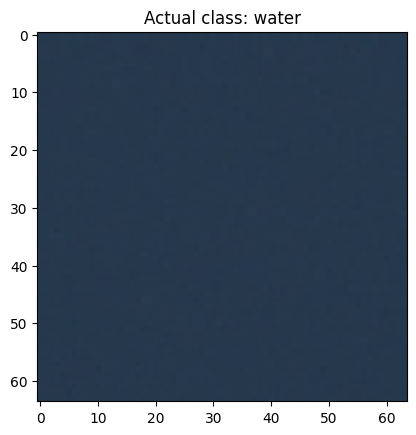

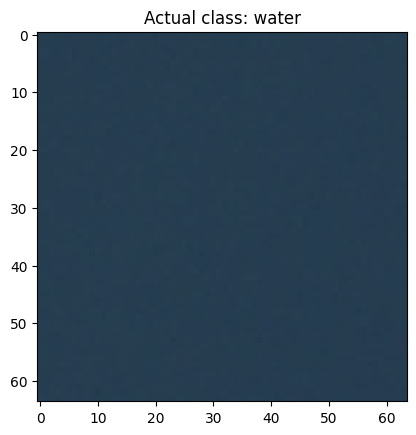

In [94]:
# plot image that miss-classifed as green area
for _, v in miss_classified_as_green_area.iterrows():
    plt.imshow(
        read_img_rgb(v["path"])
    )
    plt.title("Actual class: {}".format(v["label"]))
    plt.show()

- All of the images are water with dominant blue color
- There are images of green areas that have a dominant blue color in the dataset. That's why the model also learns that blue image might water or green area.
- 

In [95]:
# filter image that miss-classifed as water
miss_classified_as_water = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==3].index]
miss_classified_as_water

label                                           path
449       cloudy      /kaggle/input/data/cloudy/train_31954.jpg
957       cloudy      /kaggle/input/data/cloudy/train_16325.jpg
3830  green_area    /kaggle/input/data/green_area/Forest_72.jpg
3140  green_area  /kaggle/input/data/green_area/Forest_2154.jpg
3143  green_area  /kaggle/input/data/green_area/Forest_2113.jpg

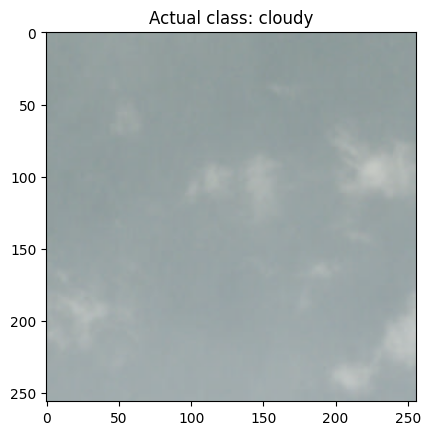

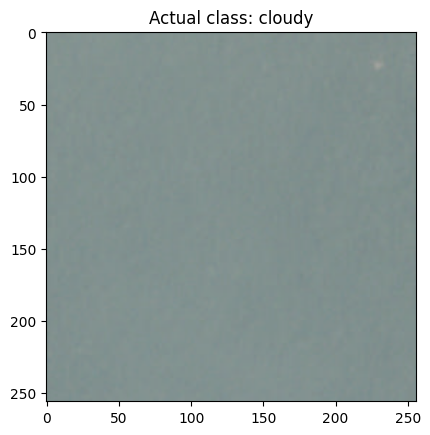

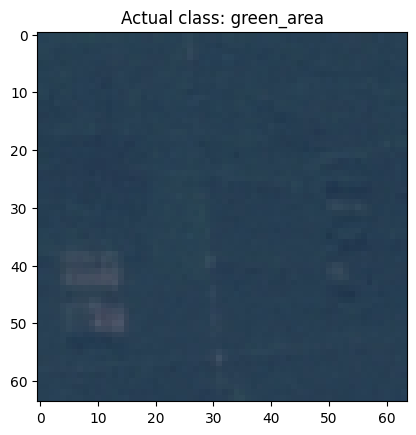

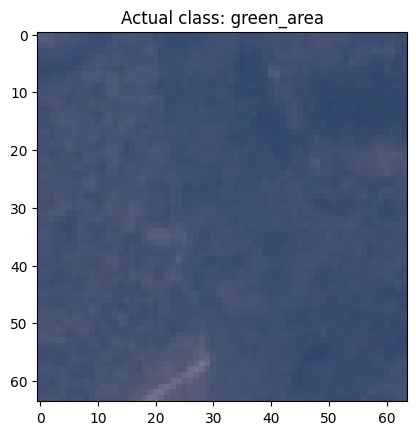

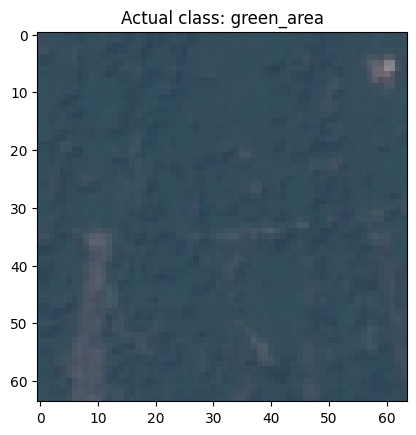

In [96]:
# plot image that miss-classifed as water
for _, v in miss_classified_as_water.iterrows():
    plt.imshow(
        read_img_rgb(v["path"])
    )
    plt.title("Actual class: {}".format(v["label"]))
    plt.show()

- All images that the model misclassified as water are having mixed green and blue colors, except the first one
- The last two images might misclassified because there's not much variance on green area and water images.

- The first misclassified image might occur as a pure case, since the model is overfitted.

- This conclude that, some green area and water images in the dataset are having mixed green and blue color.
- This misclassification also occurred because there are not enough water images similar to green areas, and vice versa, in the dataset

# Conclusion

- In this project, the best model that can be used for classification task is model with hyperparamter tuning 2.
- This model was able to achieve 94% accuracy across 4 classes.
- 94% accuracy means, `out of 100 images, this model correctly classify 94 of them`

Further improvement:
- Despite this model able to meet the minimum requirement on accuracy score, it's still overfitted. Thus, 94% accuracy on unseen data can't be trusted blindly.
- The model can be improved by applying regularization method and add more images for training and validation to overcome overfitting.


- The model also has some pattern in terms of misclassifying images, such as:
    - some water images misclassified as green area, and vice versa
    - some cloudy images misclassified as desert, and vice versa


- To encounter this problem, the dataset must be improved by:
    - providing water images that similar to green area, and vice versa.
    - providing cloudy images that similar to desert, and vice versa.